## 

# 0. 피드백 반영 부분:
#### - 차입 시점에서 알 수 없는 변수로서 `int_rate`를 추가하였습니다. 
* 해당 변수는 lending_club사에서 대출 신청자에 대한 Screening을 거친 결과 결정된 대출금리로서, 대출 신청자의 신용도, 리스크 등을 반영하여 결정되었을 것입니다. 
* 해당 변수에는 이미 타 모델의 부도 예측력이 반영되어 있는 것과 다름 없으므로 저희 모델의 예측력을 보다 공정하게 평가하기 위해 이를 제거하였습니다.  

#### - 왜도가 큰 변수들의 log값 변환에 있어 0 또는 음의 값이 있는 지 검토하였습니다.
#### - 시계열 데이터의 가정을 버리고 랜덤하게 Cross Validation을 진행하였습니다.
#### - Model Selection 과정에서 Regularlization결과 남은 변수들을 파악하였습니다.
#### - 목적함수를 보다 현실적으로 수정하였고, Test Set에서의 목적함수 값을 구해보았습니다.

# 1. 데이터 가져오기 & 더미변수 합치기

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

In [2]:
dt = pd.io.stata.read_stata('lendingclub.dta')

In [3]:
pd.DataFrame(dt.columns).to_csv("columns_list.csv")

In [4]:
#더미변수 사이에 낀 열 일단 빼놓기
elapsed_t = dt.loc[:, 'elapsed_t']
depvar = dt.loc[:, 'depvar']
debt_settlement_flag1 = dt.loc[:, 'debt_settlement_flag1']
term = dt.loc[:, 'term1']

In [5]:
#데이터프레임에서 제거
dt.drop(['elapsed_t', 'depvar', 'debt_settlement_flag1', 'term1'], 
        axis = 1, inplace = True)

In [6]:
#더미변수 열 이름 저장
lend_col = dt.columns[36:]
lend_col

Index(['emp_length1', 'emp_length2', 'emp_length3', 'emp_length4',
       'emp_length5', 'emp_length6', 'emp_length7', 'emp_length8',
       'emp_length9', 'emp_length10',
       ...
       'mths_since_recent_revol_delinq2', 'mths_since_recent_revol_delinq3',
       'mths_since_recent_revol_delinq4', 'mths_since_recent_revol_delinq5',
       'mths_since_recent_revol_delinq6', 'mths_since_recent_revol_delinq7',
       'mths_since_recent_revol_delinq8', 'mths_since_recent_revol_delinq9',
       'mths_since_recent_revol_delinq10', 'mths_since_recent_revol_delinq11'],
      dtype='object', length=293)

In [7]:
#열 설명들을 불러옴
reader = pd.io.stata.StataReader('lendingclub.dta')
header = reader.variable_labels()

In [8]:
header

{'loan_amnt': '',
 'funded_amnt': '',
 'funded_amnt_inv': '',
 'int_rate': '',
 'installment': '',
 'annual_inc': '',
 'dti': '',
 'delinq_2yrs': '',
 'fico_range_low': '',
 'fico_range_high': '',
 'inq_last_6mths': '',
 'open_acc': '',
 'pub_rec': '',
 'revol_bal': '',
 'revol_util': '',
 'total_acc': '',
 'out_prncp': '',
 'out_prncp_inv': '',
 'total_pymnt': '',
 'total_pymnt_inv': '',
 'total_rec_prncp': '',
 'total_rec_int': '',
 'total_rec_late_fee': '',
 'recoveries': '',
 'collection_recovery_fee': '',
 'last_pymnt_amnt': '',
 'last_fico_range_high': '',
 'last_fico_range_low': '',
 'collections_12_mths_ex_med': '',
 'acc_now_delinq': '',
 'tot_coll_amt': '',
 'tot_cur_bal': '',
 'chargeoff_within_12_mths': '',
 'delinq_amnt': '',
 'pub_rec_bankruptcies': '',
 'tax_liens': '',
 'emp_length1': 'emp_length==1 year',
 'emp_length2': 'emp_length==10+ years',
 'emp_length3': 'emp_length==2 years',
 'emp_length4': 'emp_length==3 years',
 'emp_length5': 'emp_length==4 years',
 'emp_le

In [9]:
#header가 dictionary 형태이므로 values만 추출하여 저장
label = pd.DataFrame({'values' : header.values()})
label = label.iloc[36:, :]

#마찬가지로 더미변수에 낀 열이름 삭제
label.drop([124, 243, 244, 245], inplace = True)

In [10]:
#'==' 뒤에 있는 항목들만 추출
label2 = pd.DataFrame(label['values'].str.split('==').str[-1])
label2_val = list(label2['values'])

In [11]:
#더미변수 열 이름과 설명들로 dictionary 생성
#데이터프레임 열 이름을 바꾸기 위해서 dictionary 자료형이 필요함
col_dict = {}

for i in range(0, len(lend_col)):
    col_dict[lend_col[i]] = label2_val[i]

In [12]:
#만들어놨던 dictionary로 더미변수 열 이름들을 변경
dt.rename(columns = col_dict, inplace = True)
dt.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,1.0000,2.0000,3.0000,4.0000,5.0000,6.0000,7.0000,8.0000,9.0000,10.0000
0,19000,19000,19000.0,0.0916,605.62,65000.0,16.36,1,670,674,...,0,1,0,0,0,0,0,0,0,0
1,10000,10000,10000.0,0.0789,312.86,58000.0,5.03,0,690,694,...,0,0,0,0,0,0,0,0,0,0
2,6000,6000,6000.0,0.1147,197.78,46900.0,24.23,2,665,669,...,1,0,0,0,0,0,0,0,0,0


In [13]:
#emp_length 더미변수 합치기
#emp_length1~emp_length12까지 한 열로 합치기
dt['emp_length'] = pd.DataFrame({'emp_length' : dt.iloc[:, 36:48].idxmax(axis = 1)})

#year 앞에 부분까지만 추출
dt['emp_length'] = dt['emp_length'].str.split('y').str[0]

#home_ownership 더미변수 합치기
dt['home_ownership'] = pd.DataFrame({'home_ownership' : dt.iloc[:, 48:54].idxmax(axis = 1)})

#verification_status 더미변수 합치기
dt['verification_status'] = pd.DataFrame({'verification_status' : dt.iloc[:, 54:57].idxmax(axis = 1)})

#purpose 더미변수 합치기
dt['purpose'] = pd.DataFrame({'purpose' : dt.iloc[:, 57:71].idxmax(axis = 1)})

#addr_state 더미변수 합치기
dt['addr_state'] = pd.DataFrame({'addr_state' : dt.iloc[:, 71:122].idxmax(axis = 1)})

#initial_list_status 더미변수 합치기
dt['initial_list_status'] = pd.DataFrame({'initial_list_status' : dt.iloc[:, 122:124].idxmax(axis = 1)})

#issue_d 더미변수 합치기
dt['issue_d'] = pd.DataFrame({'issue_d' : dt.iloc[:, 124:242].idxmax(axis = 1)})

#mths_since_last_delinq 더미변수 합치기
dt['mths_since_last_delinq'] = pd.DataFrame({'mths_since_last_delinq' : dt.iloc[:, 242:253].idxmax(axis = 1)})

#mths_since_last_major_derog 더미변수 합치기
dt['mths_since_last_major_derog'] = pd.DataFrame({'mths_since_last_major_derog' : dt.iloc[:, 253:264].idxmax(axis = 1)})

#mths_since_last_record 더미변수 합치기
dt['mths_since_last_record'] = pd.DataFrame({'mths_since_last_record' : dt.iloc[:, 264:275].idxmax(axis = 1)})

#mths_since_rcnt_il 더빈변수 합치기
dt['mths_since_rcnt_il'] = pd.DataFrame({'mths_since_rcnt_il' : dt.iloc[:, 275:286].idxmax(axis = 1)})

#mths_since_recent_bc 더미변수 합치기
dt['mths_since_recent_bc'] = pd.DataFrame({'mths_since_recent_bc' : dt.iloc[:, 286:297].idxmax(axis = 1)})

#mths_since_recent_bc_dlq 더미변수 합치기
dt['mths_since_recent_bc_dlq'] = pd.DataFrame({'mths_since_recent_bc_dlq' : dt.iloc[:, 297:308].idxmax(axis = 1)})

#mths_since_recent_inq 더미변수 합치기
dt['mths_since_recent_inq'] = pd.DataFrame({'mths_since_recent_inq' : dt.iloc[:, 308:318].idxmax(axis = 1)})

#mths_since_recent_revol_delinq 더미변수 합치기
dt['mths_since_recent_revol_delinq'] = pd.DataFrame({'mths_since_recent_revol_delinq' : dt.iloc[:, 318:329].idxmax(axis = 1)})

dt.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,initial_list_status,issue_d,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq
0,19000,19000,19000.0,0.0916,605.62,65000.0,16.36,1,670,674,...,w,674.0000,2.0000,0.0000,0.0000,3.0000,7.0000,0.0000,9.0000,2.0000
1,10000,10000,10000.0,0.0789,312.86,58000.0,5.03,0,690,694,...,w,674.0000,0.0000,0.0000,0.0000,9.0000,7.0000,0.0000,1.0000,0.0000
2,6000,6000,6000.0,0.1147,197.78,46900.0,24.23,2,665,669,...,w,674.0000,1.0000,0.0000,0.0000,1.0000,10.0000,1.0000,3.0000,1.0000


In [14]:
#삭제할 더미변수 열 이름들을 list에 담기
remove_list = list(dt.iloc[:, 36:329].columns)
#더미변수 열들 삭제
loan = dt.drop(remove_list, axis = 1).copy()

#위에서 빼놓았던 열들 다시 추가
loan['elapsed_t'] = elapsed_t
loan['depvar'] = depvar
loan['debt_settlement_flag1'] = debt_settlement_flag1
loan['term'] = term

#범주형으로 형 변환
loan['elapsed_t'] = loan['elapsed_t'].astype('object')
loan['debt_settlement_flag1'] = loan['debt_settlement_flag1'].astype('object')
loan['term'] = loan['term'].astype('object')

#수치형으로 형 변환
loan['mths_since_last_delinq'] = loan['mths_since_last_delinq'].astype('float64')
loan['mths_since_last_major_derog'] = loan['mths_since_last_major_derog'].astype('float64')
loan['mths_since_last_record'] = loan['mths_since_last_record'].astype('float64')
loan['mths_since_rcnt_il'] = loan['mths_since_rcnt_il'].astype('float64')
loan['mths_since_recent_bc'] = loan['mths_since_recent_bc'].astype('float64')
loan['mths_since_recent_bc_dlq'] = loan['mths_since_recent_bc_dlq'].astype('float64')
loan['mths_since_recent_inq'] = loan['mths_since_recent_inq'].astype('float64')
loan['mths_since_recent_revol_delinq'] = loan['mths_since_recent_revol_delinq'].astype('float64')

In [15]:
#더미변수를 합쳐서 총 55개 열 완성
loan.head(3)

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,mths_since_last_record,mths_since_rcnt_il,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,elapsed_t,depvar,debt_settlement_flag1,term
0,19000,19000,19000.0,0.0916,605.62,65000.0,16.36,1,670,674,...,0.0,3.0,7.0,0.0,9.0,2.0,49.0,0.0,1,1
1,10000,10000,10000.0,0.0789,312.86,58000.0,5.03,0,690,694,...,0.0,9.0,7.0,0.0,1.0,0.0,49.0,0.0,1,1
2,6000,6000,6000.0,0.1147,197.78,46900.0,24.23,2,665,669,...,0.0,1.0,10.0,1.0,3.0,1.0,49.0,0.0,1,1


In [16]:
# loan.to_pickle("all_data.pickle")

# 2. 특성 제한

## 2.1. 종속변수: `depvar`

In [17]:
depvar = loan['depvar'].replace([0,1], ['paid-off','default'])

In [18]:
depvar.value_counts(normalize = True, dropna=False)

paid-off    0.838209
default     0.161791
Name: depvar, dtype: float64

전체 차입자 중 83.8%가 상환(paid-off)하였고, 16.2%가 부도(default)를 낸 것으로 확인됩니다. 따라서 imbalanced dataset임을 알 수 있습니다.

## 2.2. 모델의 목적과 가정에 따른 특성 제한

### 모델의 목적
* Leding Club측에게 대출 신청자 중 누가 부도가 예상되는지 예측하는 스크리닝(Screening) 모델을 제시하는 것

### 목적에 맞는 변수 선택
#### 1) 사후 정보에 해당하는 변수: 
* 부도를 예측하는 시점은 대출자가 대출을 신청한 시점
* 해당 시점 이후에 측정된 값들과 변수들은 모두 사후정보이므로 이를 모델의 설명변수에서 제외  

#### 2) `int_rate`: 
* 대출신청자에게 제시된 금리를 의미하며 엄밀히 말하면 **사전 정보**에 해당
* 이는 Lending Club측에서 대출신청자에 대한 스크리닝을 거쳐서 결정된 값이므로 이미 Lending Club측의 부도예측 모형이 반영되어 있는 정보
* 즉 '부도 여부'라는 종속변수를 설명하는 데 있어 **독립 변수**가 아님. 따라서 모델의 목적과 취지에 맞게 이 변수 역시 제외 

### 2.2.1. 상관관계 파악

In [19]:
# 수치형 변수들 간의 상간관계
tmp = loan.iloc[:,:36]
tmp2 = pd.merge(tmp, loan.depvar, left_index = True, right_index = True)
cor = tmp2.corr()
mask = np.zeros_like(cor)
triu_idx = np.triu_indices_from(mask)
mask[triu_idx] = True

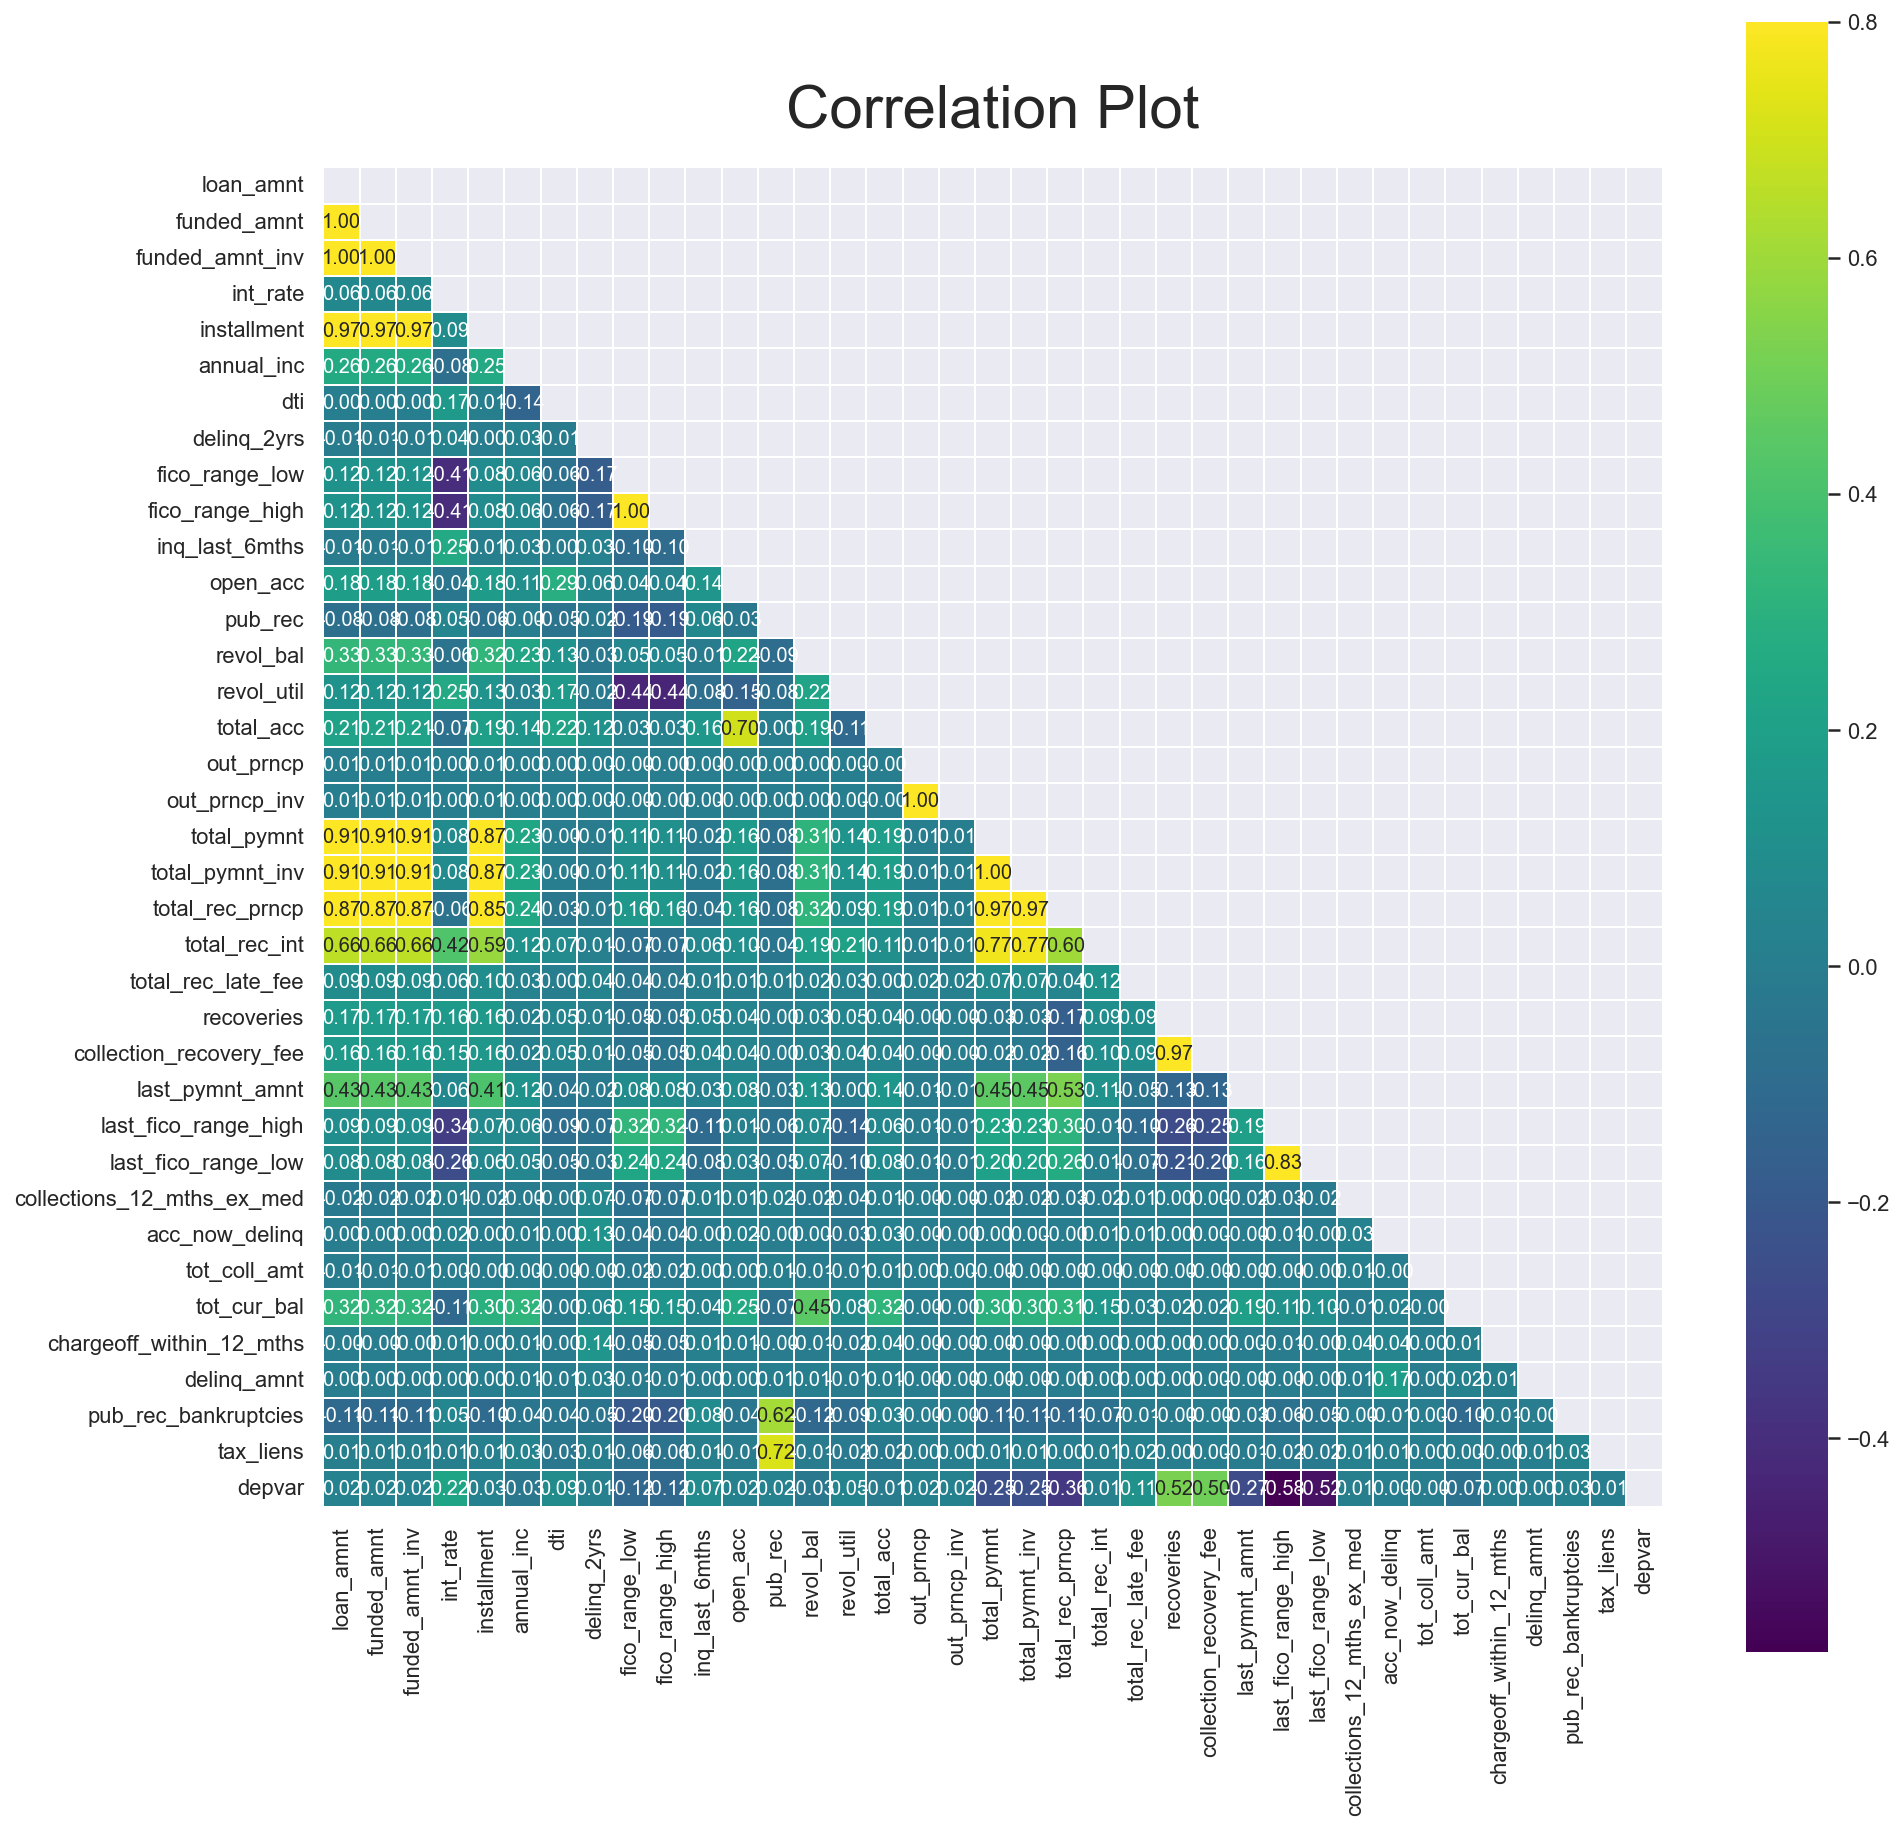

In [20]:
colormap = plt.cm.viridis
plt.figure(figsize=(15, 15))
plt.title('Correlation Plot', fontdict = {'fontsize' : 30}, pad = 20)
sns.heatmap(cor, mask = mask, vmax = 0.8, cmap = colormap, annot=True, fmt = '.2f', square = True, 
            annot_kws={'size':10}, linecolor='white', linewidths=0.1)
plt.show()

몇몇 변수간의 상관관계가 매우 높에 나타나고 있고 해당 변수의 의미가 유사해보이므로, 변수에 대한 정의를 자세히 살펴보고 의미가 유사하다면 추후 제외하도록 하겠습니다.

### 2.2.2. 결측치 파악

In [21]:
missing_fractions = loan.isnull().mean().sort_values(ascending=False)
missing_fractions.head(10)

loan_amnt                   0.0
initial_list_status         0.0
tot_coll_amt                0.0
tot_cur_bal                 0.0
chargeoff_within_12_mths    0.0
delinq_amnt                 0.0
pub_rec_bankruptcies        0.0
tax_liens                   0.0
emp_length                  0.0
home_ownership              0.0
dtype: float64

겉으로 드러나는 결측치가 존재하는 변수는 일단 없는 것으로 파악됩니다. 하지만 결측치로 인식하지 못할 수 있으므로 전처리 과정에서 자세히 살펴보도록 하겠습니다.

### 2.2.3. 차입 시점에서 알 수 없는 특성 제거

* 모델의 가정상, 차입 시점에서 해당 차입 신청자의 파산 여부를 예측하여야 합니다.
* 변수들의 의미를 살펴보면 차입 시점 이후에 기록된 변수들이 존재하므로 이를 제거해주어야 합니다.

In [22]:
print('전체 열 개수:', len(loan.columns))
print("<전체 변수 목록>" )
print(sorted(loan.columns))

전체 열 개수: 55
<전체 변수 목록>
['acc_now_delinq', 'addr_state', 'annual_inc', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag1', 'delinq_2yrs', 'delinq_amnt', 'depvar', 'dti', 'elapsed_t', 'emp_length', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'home_ownership', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'loan_amnt', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'open_acc', 'out_prncp', 'out_prncp_inv', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'recoveries', 'revol_bal', 'revol_util', 'tax_liens', 'term', 'tot_coll_amt', 'tot_cur_bal', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp

In [23]:
keep_list = ['depvar','loan_amnt','annual_inc','dti','fico_range_high', 
             'fico_range_low','inq_last_6mths','open_acc','pub_rec',
             'revol_bal', 'revol_util','total_acc','last_fico_range_high', 
             'last_fico_range_low','collections_12_mths_ex_med','acc_now_delinq',
             'tot_coll_amt','tot_cur_bal','chargeoff_within_12_mths',
             'delinq_amnt','pub_rec_bankruptcies','tax_liens','mths_since_last_delinq', 
             'mths_since_last_major_derog', 'mths_since_last_record', 
             'mths_since_rcnt_il','mths_since_recent_bc', 'mths_since_recent_bc_dlq', 
             'mths_since_recent_inq', 'mths_since_recent_revol_delinq','emp_length',
             'home_ownership','verification_status','purpose','addr_state']

In [24]:
print('사용할 열 개수:', len(keep_list))

사용할 열 개수: 35


In [25]:
drop_list = [col for col in loan.columns if col not in keep_list]

In [26]:
print('버릴 열 개수:', len(drop_list))

버릴 열 개수: 20


In [27]:
loan.drop(drop_list, axis=1, inplace=True)
loan.shape

(1092919, 35)

In [28]:
print(list(loan.columns))

['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'chargeoff_within_12_mths', 'delinq_amnt', 'pub_rec_bankruptcies', 'tax_liens', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'depvar']


## 2.3. 분포 파악

In [29]:
def plot_var(col_name, full_name, continuous):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    if continuous:
        sns.distplot(loan.loc[loan[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(loan[col_name], order=sorted(loan[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.grid()
    ax1.set_title(full_name)

    if continuous:
        sns.boxplot(x=col_name, y='depvar', data=loan, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by depvar')
    else:
        charge_off_rates = loan.groupby(col_name)['depvar'].value_counts(normalize=True).loc[:,'charged_off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    ax2.grid()
    
    plt.tight_layout()

In [30]:
loan['depvar'].replace([0,1], ['fully_paid','charged_off'], inplace=True)

In [31]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1092919 entries, 0 to 1092918
Data columns (total 35 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   loan_amnt                       1092919 non-null  int32  
 1   annual_inc                      1092919 non-null  float64
 2   dti                             1092919 non-null  float64
 3   fico_range_low                  1092919 non-null  int16  
 4   fico_range_high                 1092919 non-null  int16  
 5   inq_last_6mths                  1092919 non-null  int8   
 6   open_acc                        1092919 non-null  int16  
 7   pub_rec                         1092919 non-null  int8   
 8   revol_bal                       1092919 non-null  int32  
 9   revol_util                      1092919 non-null  float64
 10  total_acc                       1092919 non-null  int16  
 11  last_fico_range_high            1092919 non-null  int16  
 12  

In [32]:
pd.DataFrame(loan.columns).to_csv("columns.csv")

### 2.3.1. loan_amnt

의미: 채무자(borrower)가 신청한 대출액

In [33]:
loan.loan_amnt.describe()

count    1.092919e+06
mean     1.364630e+04
std      8.441163e+03
min      1.000000e+03
25%      7.125000e+03
50%      1.200000e+04
75%      1.900000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

범위: 최소 1000, 최대 40,000, 평균 13,646, 중간값: 12,000

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


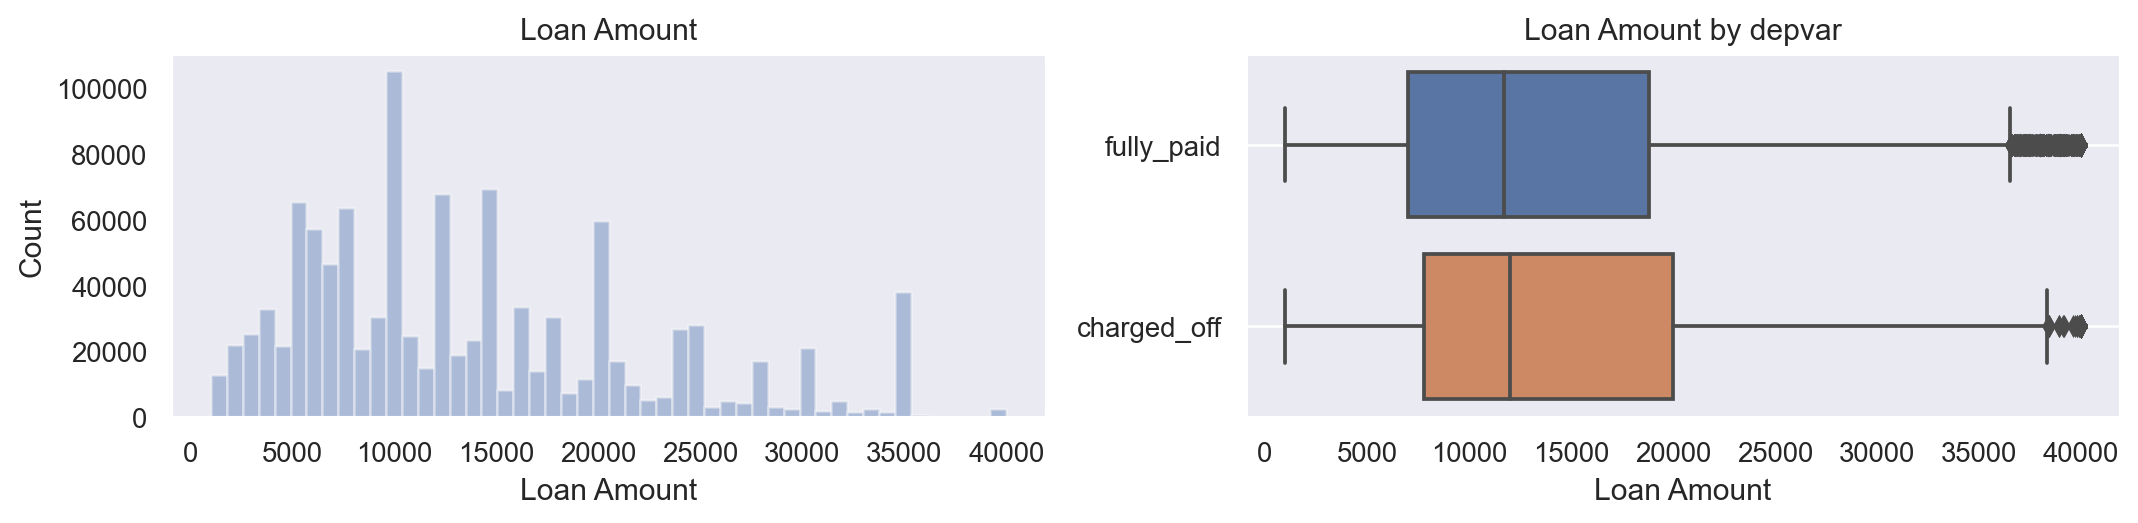

In [34]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

In [35]:
loan.groupby('depvar')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,14122.470649,8497.606175,1000.0,7775.0,12000.0,20000.0,40000.0
fully_paid,916095.0,13554.392230,8427.131877,1000.0,7000.0,11700.0,18825.0,40000.0


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [36]:
charged_off_loan_amnt = loan.loc[loan.depvar=='charged_off', 'loan_amnt']
fully_paid_loan_amnt = loan.loc[loan.depvar=='fully_paid', 'loan_amnt']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_loan_amnt, fully_paid_loan_amnt)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: 25.917, p=value:0.0000


상환 그룹보다 부도 그룹의 평균 loan amount가 상대적으로, 유의하게 많음

### 2.3.2. annual_inc

의미: (The monthly payment owed by the borrower if the loan originates.)

In [37]:
loan.annual_inc.describe()

count    1.092919e+06
mean     7.562999e+04
std      8.994245e+04
min      3.000000e+03
25%      4.500000e+04
50%      6.400000e+04
75%      9.000000e+04
max      6.100000e+07
Name: annual_inc, dtype: float64

범위: 최소 3,000, 최대 61,000,000, 평균 75,630, 중간값: 64,000 → 범위(range)값이 너무 크므로 로그값으로 변환

In [38]:
loan['log_annual_inc']=loan['annual_inc'].apply(lambda x: np.log10(x+1))

In [39]:
loan.drop('annual_inc', axis=1, inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


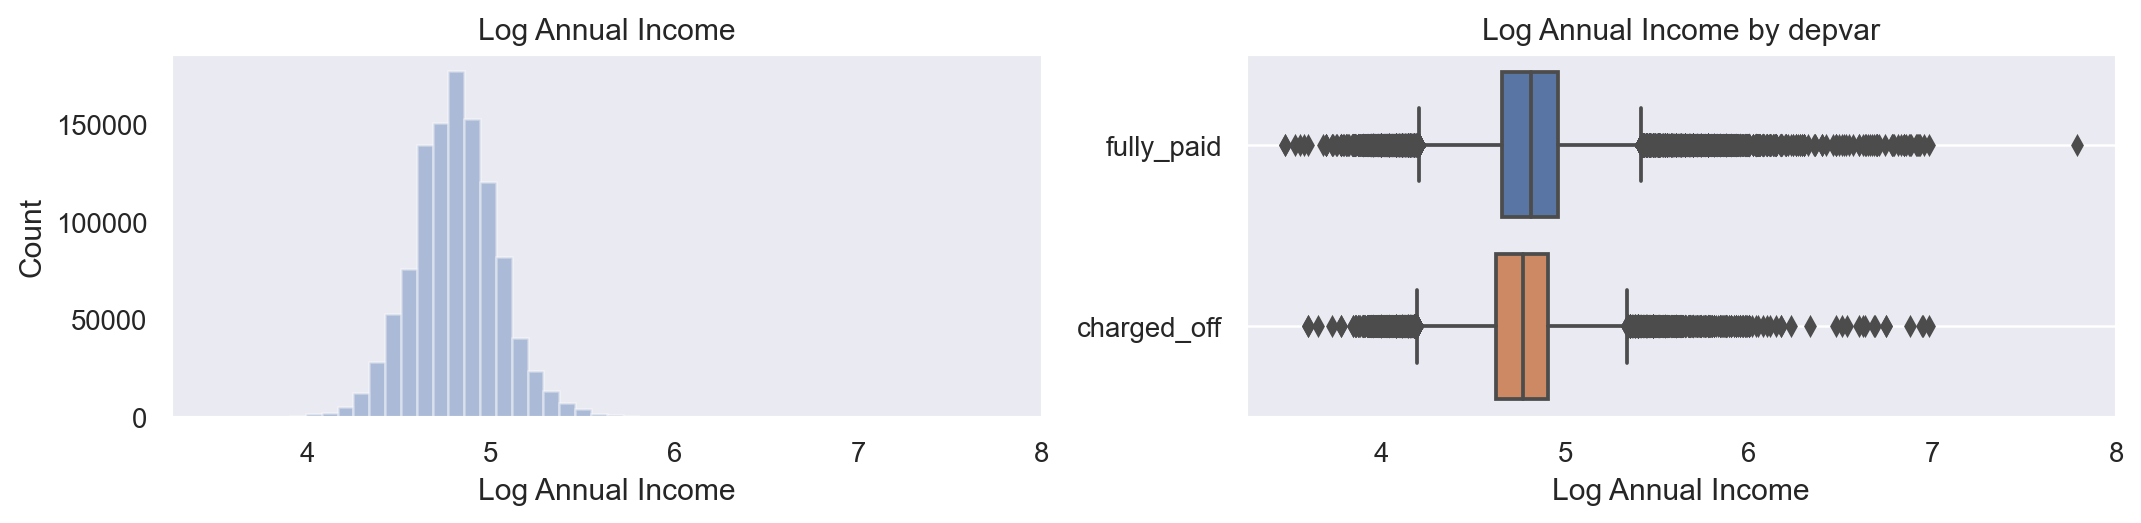

In [40]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

In [41]:
loan.groupby('depvar')['log_annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,4.769164,0.230932,3.602169,4.622382,4.773811,4.908490,6.981051
fully_paid,916095.0,4.816584,0.235748,3.477266,4.659197,4.812920,4.961288,7.785330


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [42]:
charged_off_log_annual_inc = loan.loc[loan.depvar=='charged_off', 'log_annual_inc']
fully_paid_log_annual_inc = loan.loc[loan.depvar=='fully_paid', 'log_annual_inc']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_log_annual_inc, fully_paid_log_annual_inc)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: -77.693, p=value:0.0000


부도 그룹보다 상환 그룹의 평균 log_annual_inc가 상대적으로, 유의하게 높음.

### 2.3.3. dti

의미: (A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.)

In [43]:
loan.dti.describe()

count    1.092919e+06
mean     1.818105e+01
std      8.321510e+00
min     -1.000000e+00
25%      1.192000e+01
50%      1.768000e+01
75%      2.410000e+01
max      4.996000e+01
Name: dti, dtype: float64

범위: 최소 -1, 최대 50, 평균 18, 중간값: 17.7

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


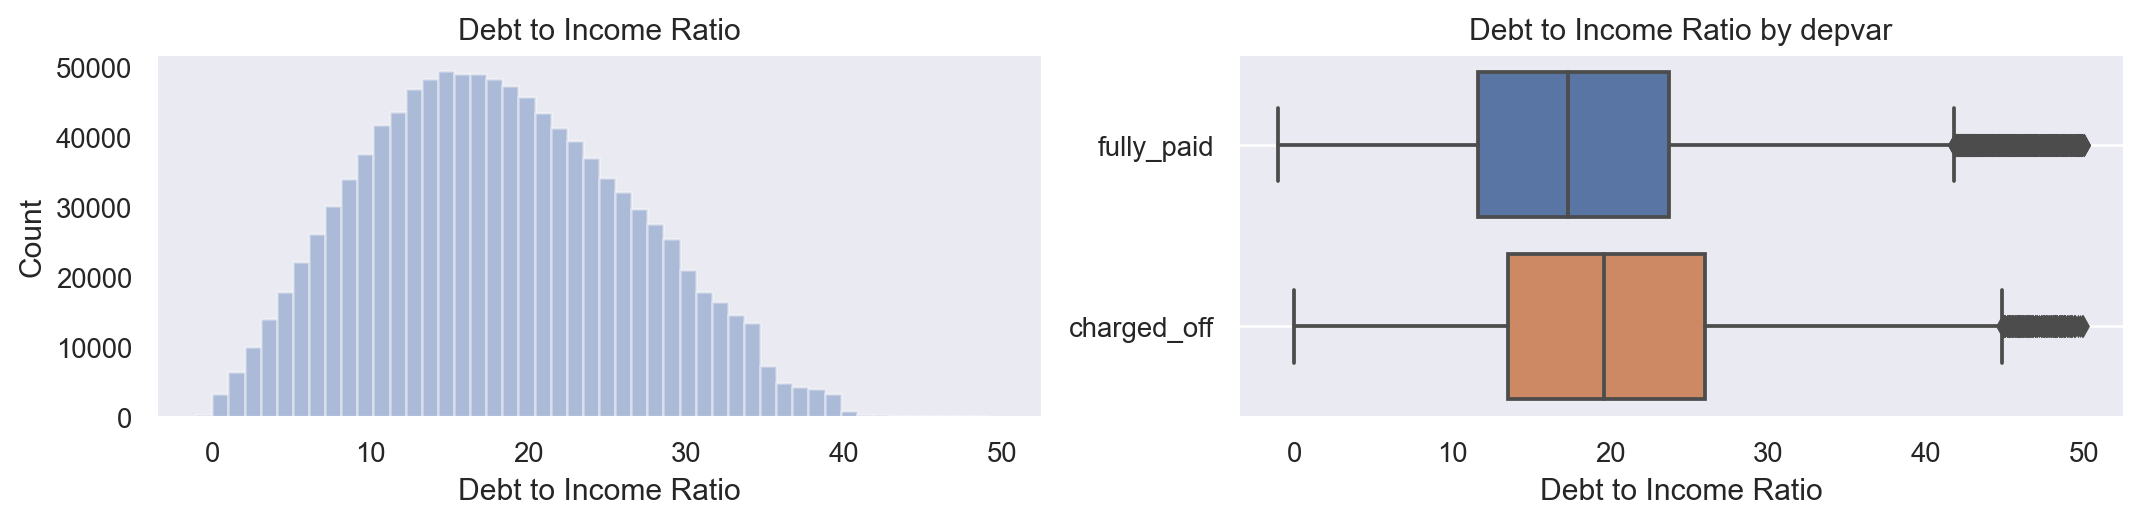

In [44]:
plot_var('dti', 'Debt to Income Ratio', continuous=True)

In [45]:
loan.groupby('depvar')['dti'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,19.807906,8.479744,0.0,13.51,19.60,26.03,49.93
fully_paid,916095.0,17.867036,8.253787,-1.0,11.65,17.31,23.69,49.96


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [46]:
charged_off_dti = loan.loc[loan.depvar=='charged_off', 'dti']
fully_paid_dti = loan.loc[loan.depvar=='fully_paid', 'dti']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_dti, fully_paid_dti)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: 90.126, p=value:0.0000


상환 그룹보다 부도 그룹의 평균 dti가 상대적으로, 유의하게 높음.

### 2.3.4. fico_range_low/high

의미: (The lower/upper boundary range the borrower’s FICO at loan origination belongs to.)

In [47]:
loan[['fico_range_low','fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1.092919e+06,1.092919e+06
mean,6.942867e+02,6.982868e+02
std,3.061425e+01,3.061490e+01
min,6.600000e+02,6.640000e+02
25%,6.700000e+02,6.740000e+02
50%,6.850000e+02,6.890000e+02
75%,7.100000e+02,7.140000e+02
max,8.450000e+02,8.500000e+02


In [48]:
loan[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


다중 공선성 문제로 두 값의 평균치를 `fico_score`에 저장하여 사용

In [49]:
loan['fico_score'] = 0.5*loan['fico_range_low'] + 0.5*loan['fico_range_high']

In [50]:
loan.drop(['fico_range_low','fico_range_high'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


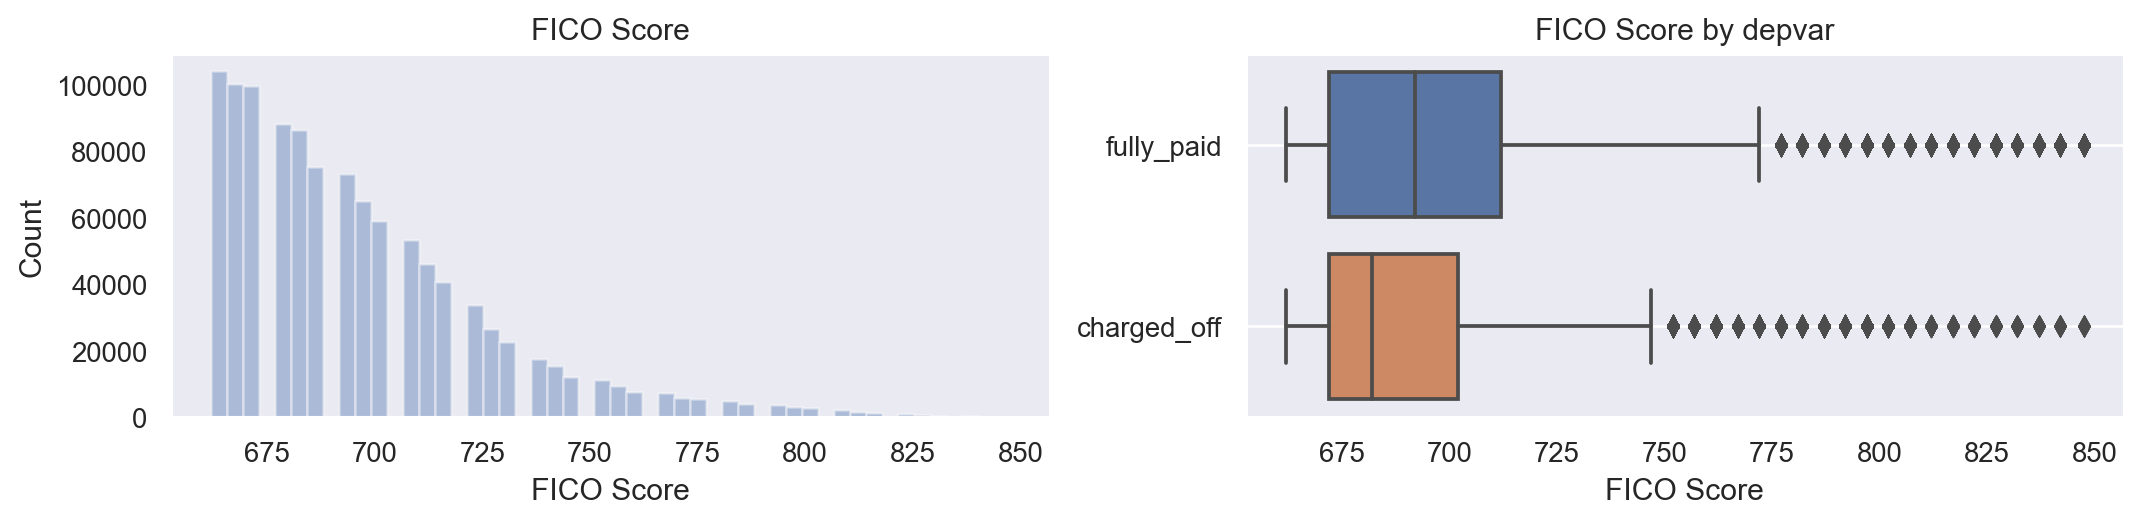

In [51]:
plot_var('fico_score', 'FICO Score', continuous=True)

In [52]:
loan.groupby('depvar')['fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,688.040628,24.422497,662.0,672.0,682.0,702.0,847.5
fully_paid,916095.0,697.878401,31.422515,662.0,672.0,692.0,712.0,847.5


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [53]:
charged_off_fico_score = loan.loc[loan.depvar=='charged_off', 'fico_score']
fully_paid_fico_score = loan.loc[loan.depvar=='fully_paid', 'fico_score']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_fico_score, fully_paid_fico_score)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: -124.588, p=value:0.0000


In [54]:
charged_off_fico_score = loan.loc[loan.depvar=='charged_off', 'fico_score']
fully_paid_fico_score = loan.loc[loan.depvar=='fully_paid', 'fico_score']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_fico_score, fully_paid_fico_score)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: -124.588, p=value:0.0000


부도 그룹보다 상환 그룹의 평균 fico_score가 상대적으로, 유의하게 높음. (10pt)

### 2.3.5 open_acc

의미: (The number of open credit lines in the borrower's credit file.)

In [55]:
loan.open_acc.describe()

count    1.092919e+06
mean     1.157962e+01
std      5.429423e+00
min      1.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      9.000000e+01
Name: open_acc, dtype: float64

범위: 최소 1, 최대 90, 평균 11.5, 중간값: 11

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


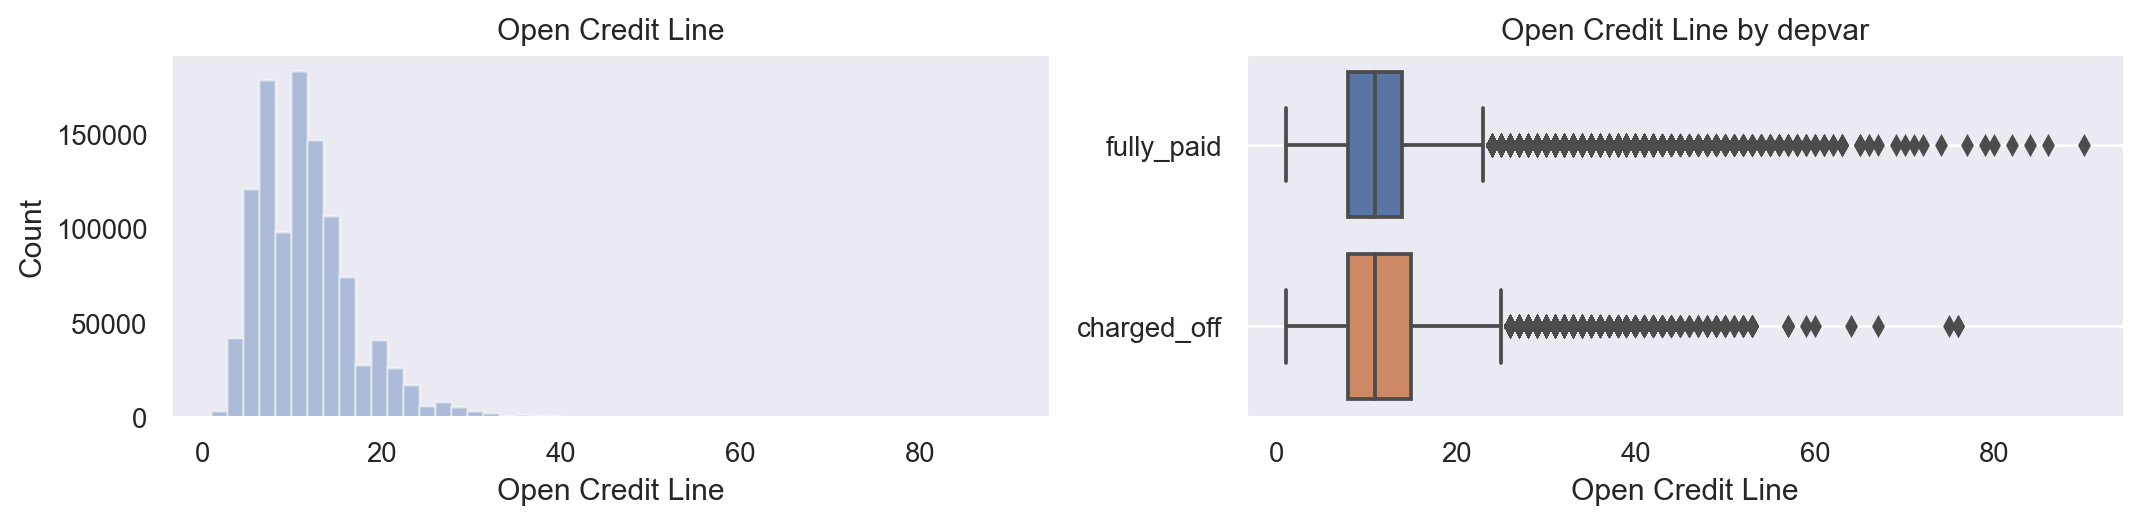

In [56]:
plot_var('open_acc', 'Open Credit Line', continuous=True)

In [57]:
loan.groupby('depvar')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,11.806881,5.517532,1.0,8.0,11.0,15.0,76.0
fully_paid,916095.0,11.535759,5.411156,1.0,8.0,11.0,14.0,90.0


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [58]:
charged_off_open_acc = loan.loc[loan.depvar=='charged_off', 'open_acc']
fully_paid_open_acc = loan.loc[loan.depvar=='fully_paid', 'open_acc']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_open_acc, fully_paid_open_acc)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: 19.228, p=value:0.0000


상환 그룹보다 부도 그룹의 평균 open_acc가 상대적으로, 유의하게 높음. (그러나 큰 차이는 없음)

### 2.3.6 pub_rec

의미: (Number of derogatory public records.)

In [59]:
loan.pub_rec.describe()

count    1.092919e+06
mean     2.278147e-01
std      6.400227e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.600000e+01
Name: pub_rec, dtype: float64

 범위: 최소 0, 최대 86, 평균 0.2, 중간값: 0

 왜도가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [60]:
loan['log_pub_rec'] = loan['pub_rec'].apply(lambda x: np.log10(x+1))
loan.drop('pub_rec',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


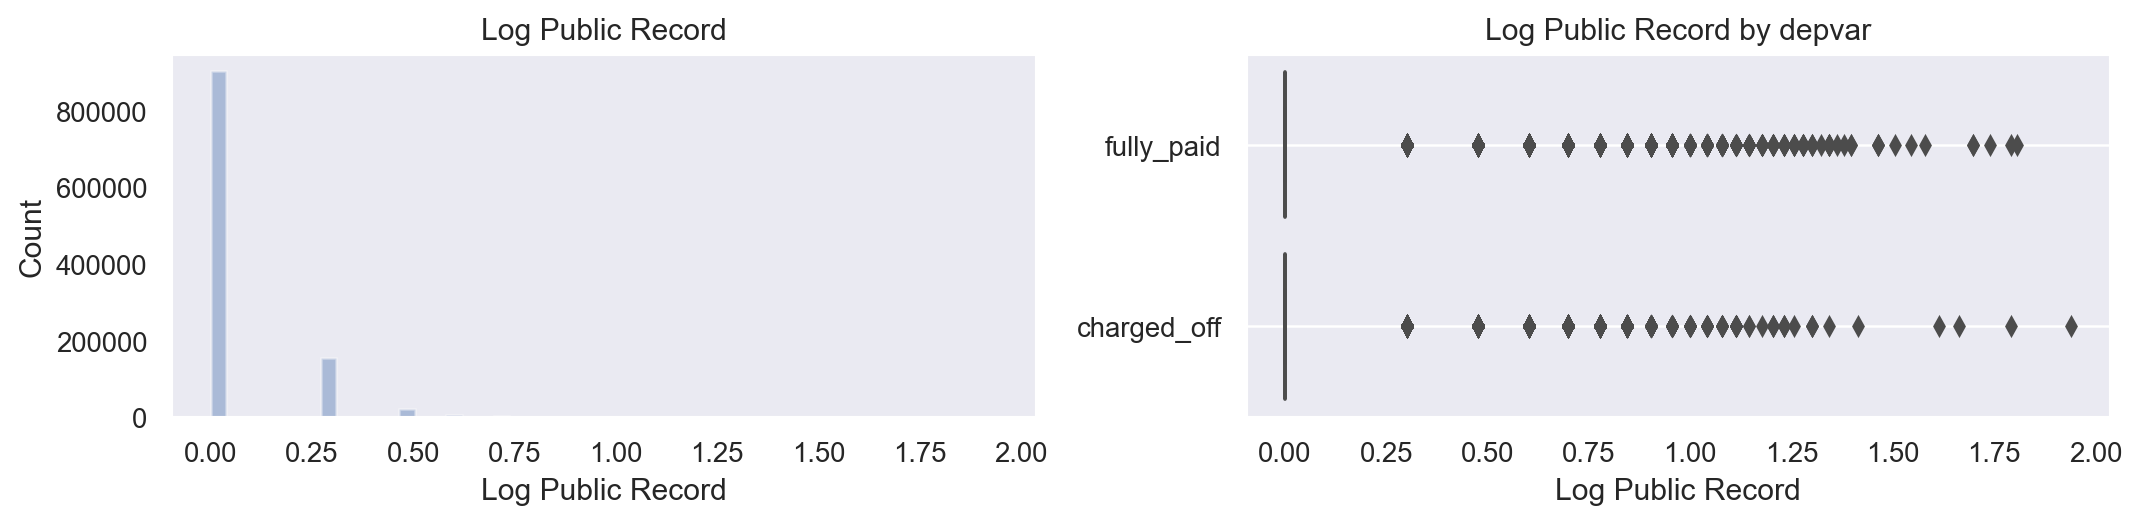

In [61]:
plot_var('log_pub_rec', 'Log Public Record', continuous=True)

상환 그룹보다 부도 그룹의 평균 pub_rec가 상대적으로, 유의하게 높음. (그러나 큰 차이는 없음)

### 2.3.7 revol_bal

의미: (Total credit revolving balance.)

In [62]:
loan.revol_bal.describe()

count    1.092919e+06
mean     1.633953e+04
std      2.264732e+04
min      0.000000e+00
25%      6.055000e+03
50%      1.113500e+04
75%      1.975600e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

 범위: 최소 0, 최대 2,904,836, 평균 16,340, 중간값: 11,135 → 범위가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [63]:
loan['log_revol_bal'] = loan['revol_bal'].apply(lambda x: np.log10(x+1))
loan.drop('revol_bal',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


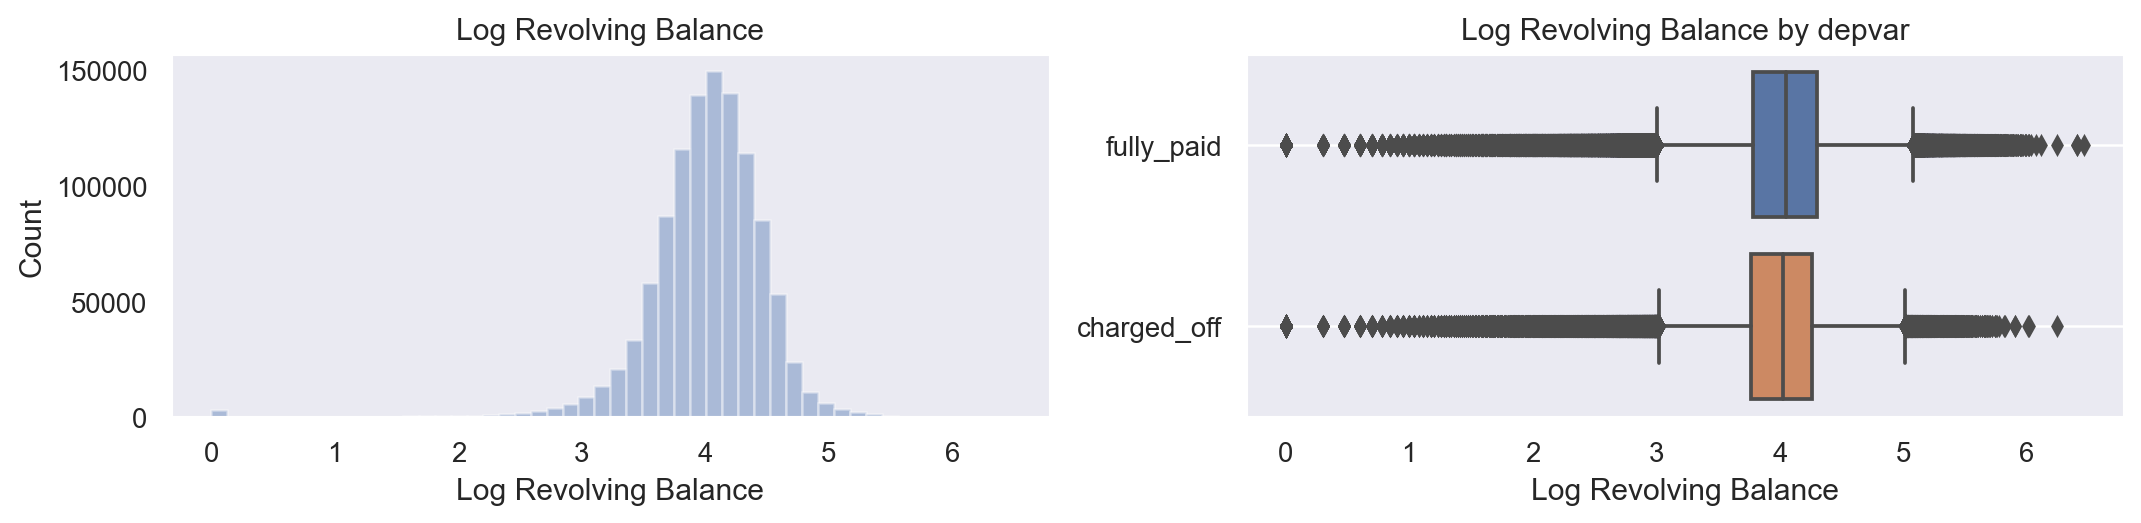

In [64]:
plot_var('log_revol_bal', 'Log Revolving Balance', continuous=True)

In [65]:
loan.groupby('depvar')['log_revol_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,3.984889,0.466796,0.0,3.767082,4.026370,4.264275,6.242223
fully_paid,916095.0,4.013909,0.487395,0.0,3.785187,4.050766,4.301854,6.463122


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [66]:
charged_off_log_revol_bal = loan.loc[loan.depvar=='charged_off', 'log_revol_bal']
fully_paid_log_revol_bal = loan.loc[loan.depvar=='fully_paid', 'log_revol_bal']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_log_revol_bal, fully_paid_log_revol_bal)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: -23.077, p=value:0.0000


### 2.3.8 revol_util

의미: (Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.)

In [67]:
loan.revol_util.describe()

count    1.092919e+06
mean     5.311223e-01
std      2.389062e-01
min      0.000000e+00
25%      3.530000e-01
50%      5.350000e-01
75%      7.150000e-01
max      8.923000e+00
Name: revol_util, dtype: float64

 범위: 최소 0, 최대 8.9, 평균 0.53, 중간값: 0.53

왜도가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [68]:
loan['log_revol_util'] = loan['revol_util'].apply(lambda x: np.log10(x+1))
loan.drop('revol_util',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


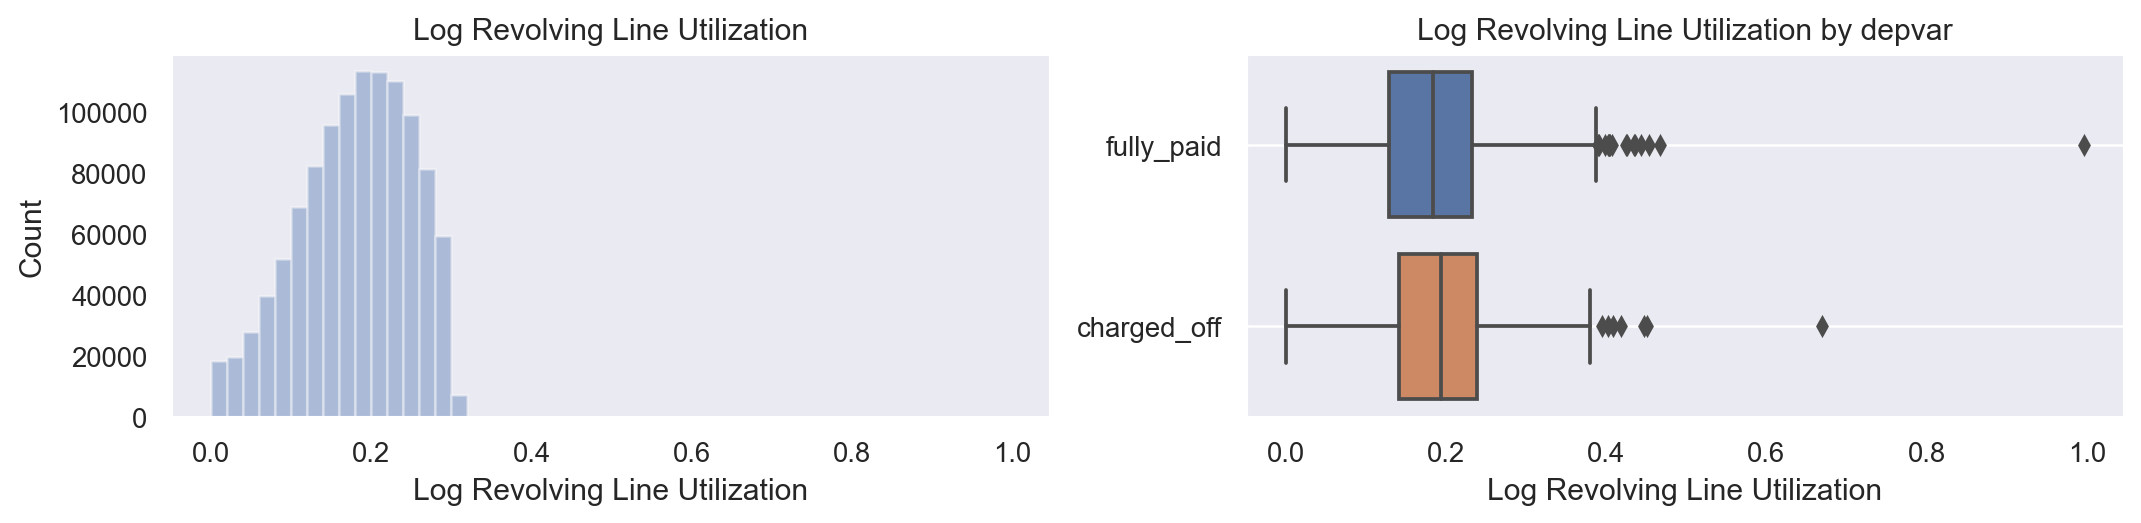

In [69]:
plot_var('log_revol_util', 'Log Revolving Line Utilization', continuous=True)

여전히 극단치 제거해줄 필요가 있어보임

In [70]:
loan.groupby('depvar')['log_revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,0.186939,0.067164,0.0,0.142076,0.193681,0.239049,0.668945
fully_paid,916095.0,0.178098,0.070162,0.0,0.129368,0.184407,0.233250,0.996643


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [71]:
charged_off_revol_util = loan.loc[loan.depvar=='charged_off', 'log_revol_util']
fully_paid_revol_util = loan.loc[loan.depvar=='fully_paid', 'log_revol_util']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_revol_util, fully_paid_revol_util)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: 48.847, p=value:0.0000


### 2.3.9 total_acc

의미: (The total number of credit lines currently in the borrower's credit file.)

In [72]:
loan.total_acc.describe()

count    1.092919e+06
mean     2.472208e+01
std      1.186147e+01
min      2.000000e+00
25%      1.600000e+01
50%      2.300000e+01
75%      3.100000e+01
max      1.760000e+02
Name: total_acc, dtype: float64

 범위: 최소 0, 최대 8.9, 평균 0.53, 중간값: 0.53

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


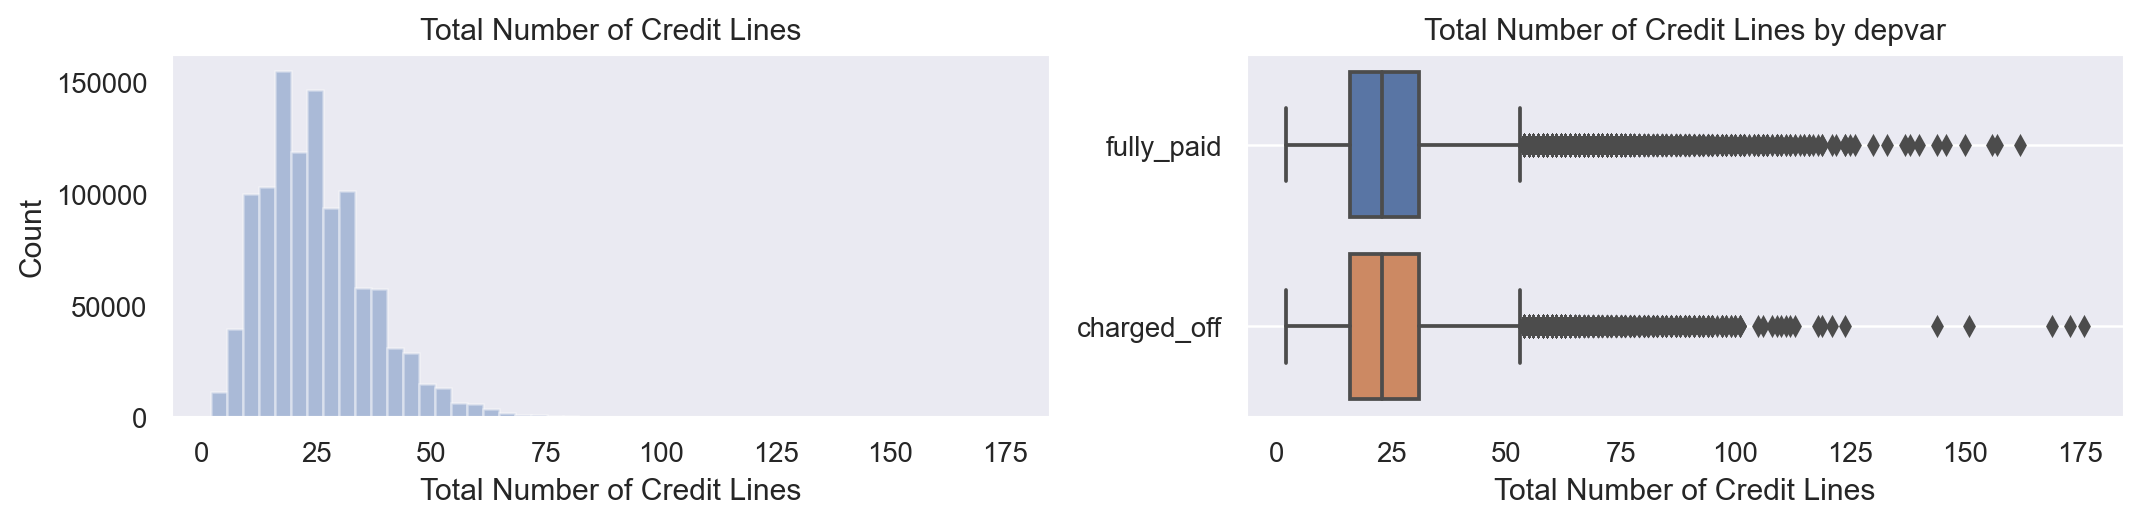

In [73]:
plot_var('total_acc', 'Total Number of Credit Lines', continuous=True)

In [74]:
loan.groupby('depvar')['total_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,24.507205,11.990099,2.0,16.0,23.0,31.0,176.0
fully_paid,916095.0,24.763559,11.836033,2.0,16.0,23.0,31.0,162.0


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [75]:
charged_off_total_acc = loan.loc[loan.depvar=='charged_off', 'total_acc']
fully_paid_total_acc = loan.loc[loan.depvar=='fully_paid', 'total_acc']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_total_acc, fully_paid_total_acc)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: -8.321, p=value:0.0000


### 2.3.10 last_fico_range_low/high

의미: (The lower/upper boundary range the borrower’s last FICO at loan origination belongs to.)

In [76]:
loan[['last_fico_range_low','last_fico_range_high']].describe()

,last_fico_range_low,last_fico_range_high
count,1.092919e+06,1.092919e+06
mean,6.632270e+02,6.790201e+02
std,1.286379e+02,8.126385e+01
min,0.000000e+00,0.000000e+00
25%,6.250000e+02,6.290000e+02
50%,6.900000e+02,6.940000e+02
75%,7.300000e+02,7.340000e+02
max,8.450000e+02,8.500000e+02


In [77]:
loan[['last_fico_range_low','last_fico_range_high']].corr()

,last_fico_range_low,last_fico_range_high
last_fico_range_low,1.000000,0.834775
last_fico_range_high,0.834775,1.000000


다중 공선성 문제로 두 값의 평균치를 `last_fico_score`에 저장하여 사용

In [78]:
loan['last_fico_score'] = 0.5*loan['last_fico_range_low'] + 0.5*loan['last_fico_range_high']

In [79]:
loan.drop(['last_fico_range_low','last_fico_range_high'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


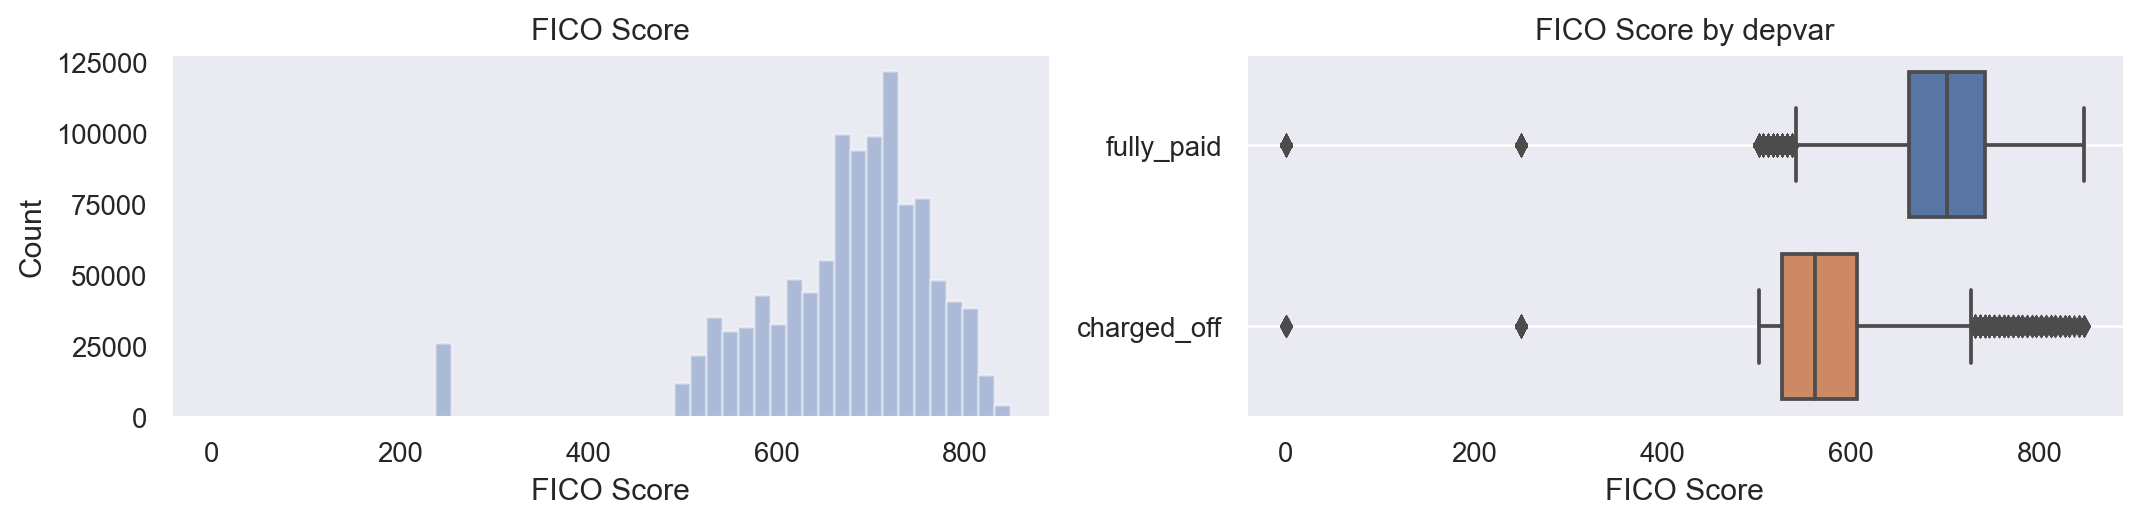

In [80]:
plot_var('last_fico_score', 'FICO Score', continuous=True)

In [81]:
loan.groupby('depvar')['last_fico_score'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,541.209078,115.360560,0.0,527.0,562.0,607.0,847.5
fully_paid,916095.0,696.199532,75.201103,0.0,662.0,702.0,742.0,847.5


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [82]:
charged_off_fico_score = loan.loc[loan.depvar=='charged_off', 'last_fico_score']
fully_paid_fico_score = loan.loc[loan.depvar=='fully_paid', 'last_fico_score']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_fico_score, fully_paid_fico_score)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: -718.681, p=value:0.0000


In [83]:
charged_off_fico_score = loan.loc[loan.depvar=='charged_off', 'fico_score']
fully_paid_fico_score = loan.loc[loan.depvar=='fully_paid', 'fico_score']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_fico_score, fully_paid_fico_score)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: -124.588, p=value:0.0000


부도 그룹보다 상환 그룹의 평균 last_fico_score가 상대적으로, 유의하게 높음.

### 2.3.11 acc_now_delinq

의미: (The number of accounts on which the borrower is now delinquent.)

In [84]:
loan.acc_now_delinq.describe()

count    1.092919e+06
mean     5.880582e-03
std      8.361557e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.400000e+01
Name: acc_now_delinq, dtype: float64

 범위: 최소 0, 최대 14, 평균 0.005, 중간값: 0

왜도가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [85]:
loan['log_acc_now_delinq'] = loan['acc_now_delinq'].apply(lambda x: np.log10(x+1))
loan.drop('acc_now_delinq',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


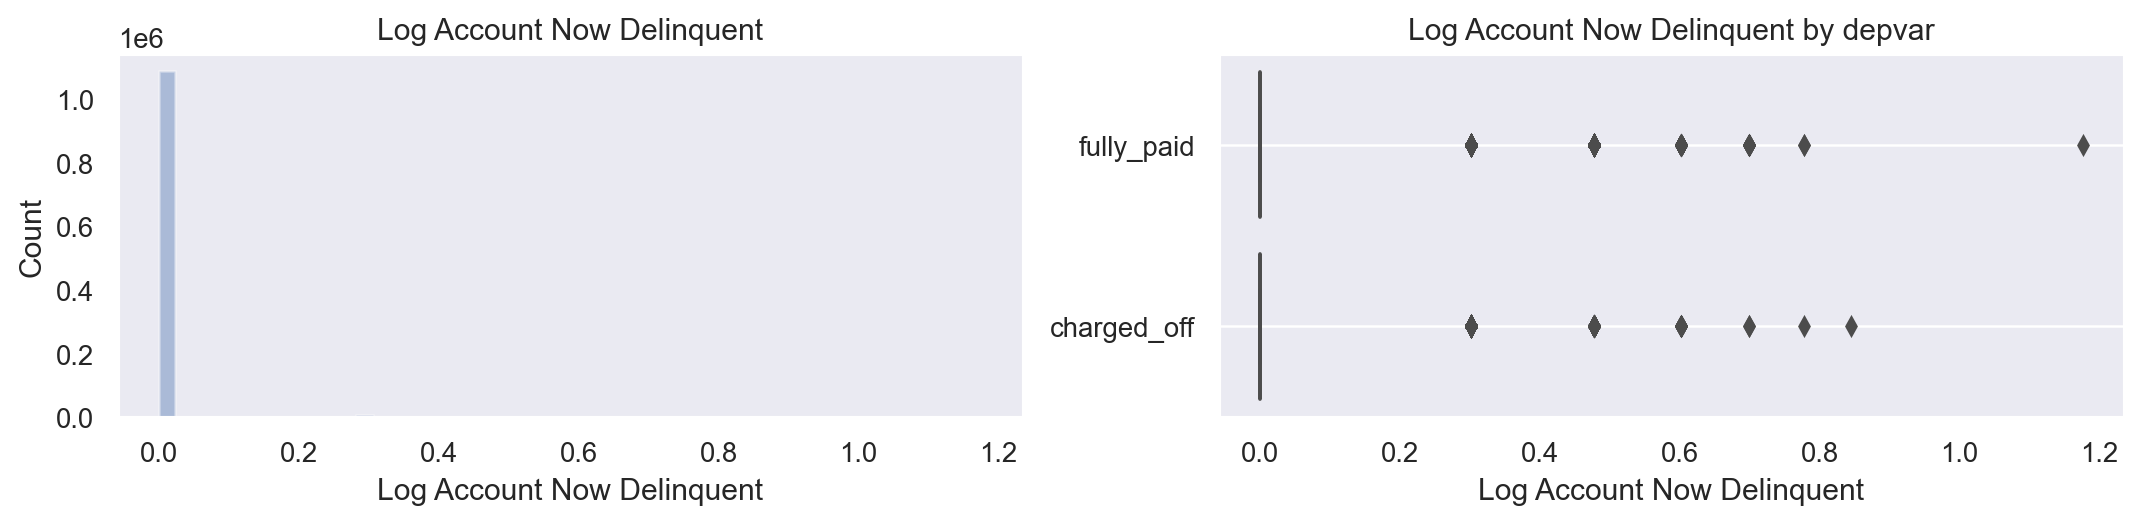

In [86]:
plot_var('log_acc_now_delinq', 'Log Account Now Delinquent', continuous=True)

In [87]:
loan.groupby('depvar')['log_acc_now_delinq'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,0.001826,0.024272,0.0,0.0,0.0,0.0,0.845098
fully_paid,916095.0,0.001692,0.023244,0.0,0.0,0.0,0.0,1.176091


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [88]:
charged_off_total_acc = loan.loc[loan.depvar=='charged_off', 'log_acc_now_delinq']
fully_paid_total_acc = loan.loc[loan.depvar=='fully_paid', 'log_acc_now_delinq']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_total_acc, fully_paid_total_acc)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: 2.211, p=value:0.0270


### 2.3.12 tot_coll_amt

의미: (Total collection amounts ever owed.)

In [89]:
loan.tot_coll_amt.describe()

count    1.092919e+06
mean     2.452099e+02
std      9.010194e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      9.152545e+06
Name: tot_coll_amt, dtype: float64

 범위: 최소 0, 최대 9152545, 평균 245, 중간값: 0

왜도가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [90]:
loan['log_tot_coll_amt'] = loan['tot_coll_amt'].apply(lambda x: np.log10(x+1))
loan.drop('tot_coll_amt',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


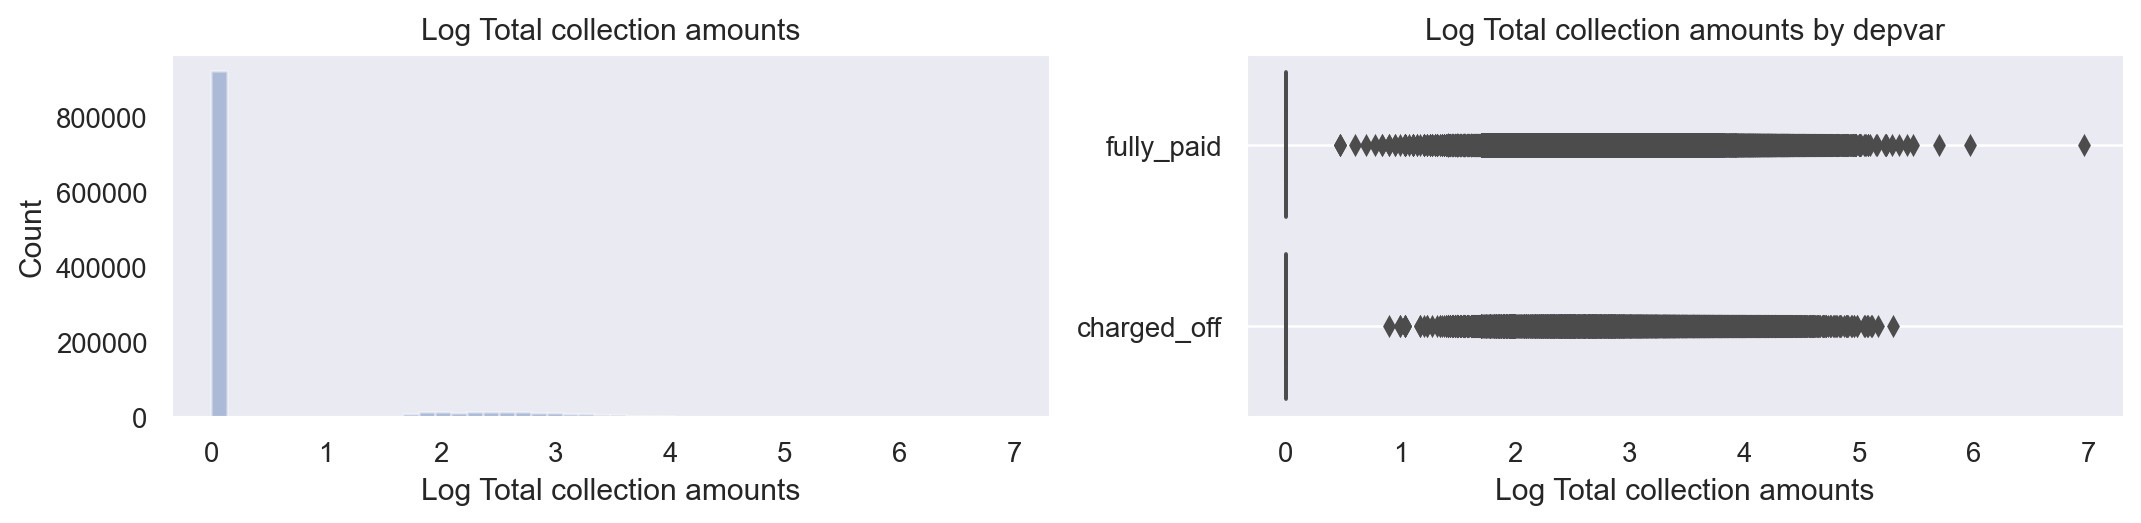

In [91]:
plot_var('log_tot_coll_amt', 'Log Total collection amounts', continuous=True)

In [92]:
loan.groupby('depvar')['log_tot_coll_amt'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,0.449637,1.023272,0.0,0.0,0.0,0.0,5.296152
fully_paid,916095.0,0.404258,0.983129,0.0,0.0,0.0,0.0,6.961542


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [93]:
charged_off_total_acc = loan.loc[loan.depvar=='charged_off', 'log_tot_coll_amt']
fully_paid_total_acc = loan.loc[loan.depvar=='fully_paid', 'log_tot_coll_amt']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_total_acc, fully_paid_total_acc)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: 17.652, p=value:0.0000


### 2.3.13 tot_cur_bal

의미: (Total current balance of all accounts.)

In [94]:
loan.tot_cur_bal.describe()

count    1.092919e+06
mean     1.349993e+05
std      1.552666e+05
min      0.000000e+00
25%      2.764300e+04
50%      7.225100e+04
75%      2.007135e+05
max      8.000078e+06
Name: tot_cur_bal, dtype: float64

 범위: 최소 0, 최대 9152545, 평균 245, 중간값: 0

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


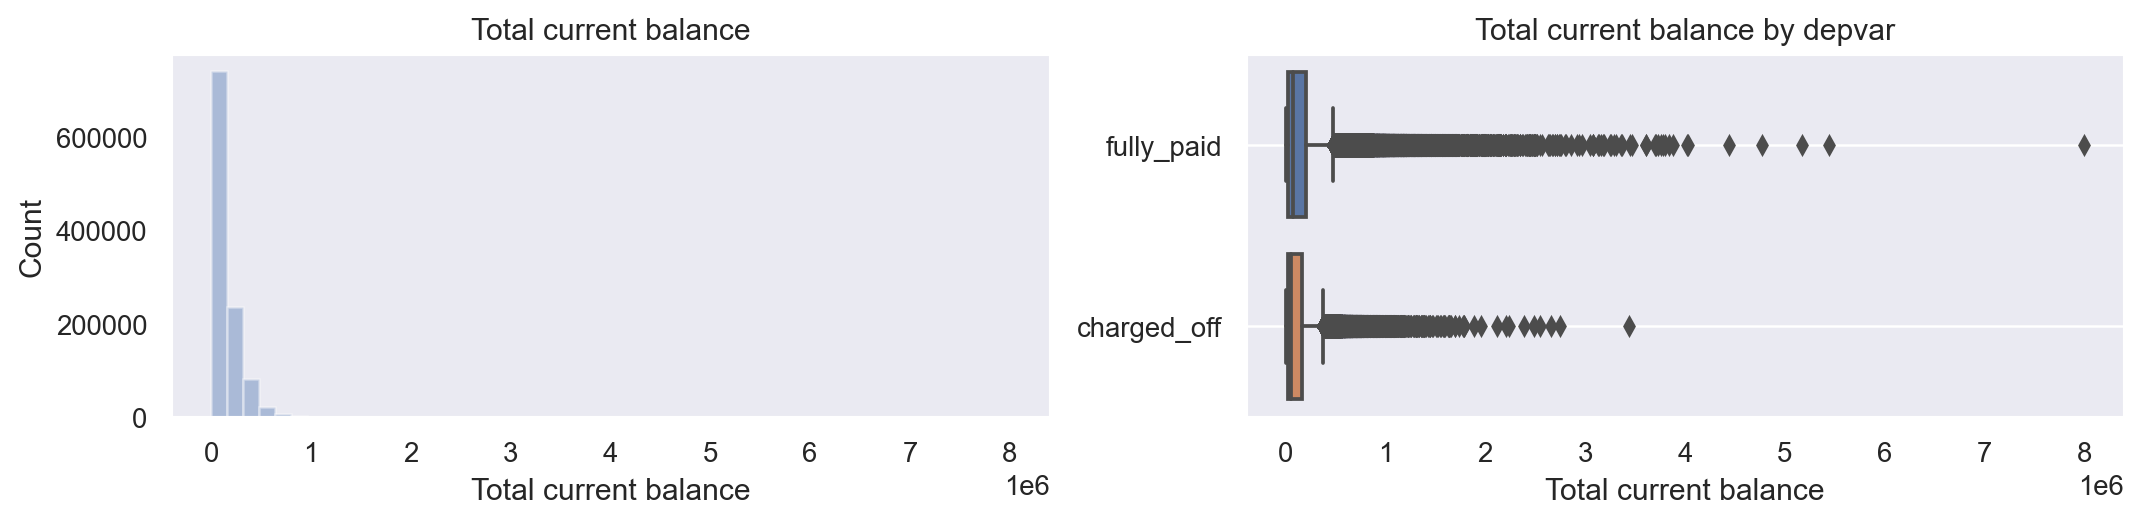

In [95]:
plot_var('tot_cur_bal', 'Total current balance', continuous=True)

In [96]:
loan.groupby('depvar')['tot_cur_bal'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,111948.905827,131519.07086,0.0,25105.0,54908.5,163409.0,3437283.0
fully_paid,916095.0,139448.489180,159059.50712,0.0,28258.5,77188.0,207649.0,8000078.0


상환, 부도 두 집단간 평균 차이가 유의미한지 t-test진행

In [97]:
charged_off_total_acc = loan.loc[loan.depvar=='charged_off', 'tot_cur_bal']
fully_paid_total_acc = loan.loc[loan.depvar=='fully_paid', 'tot_cur_bal']

t_stat, p_value, df = sm.stats.ttest_ind(charged_off_total_acc, fully_paid_total_acc)
print('t-stat: {:.3f}, p=value:{:.4f}'.format(t_stat, p_value))

t-stat: -68.331, p=value:0.0000


### 2.3.14 chargeoff_within_12_mths

의미: (Number of charge-offs within 12 months.)

In [98]:
loan.chargeoff_within_12_mths.describe()

count    1.092919e+06
mean     9.476457e-03
std      1.112018e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+01
Name: chargeoff_within_12_mths, dtype: float64

왜도가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [99]:
loan['log_chargeoff_within_12_mths'] = loan['chargeoff_within_12_mths'].apply(lambda x: np.log10(x+1))
loan.drop('chargeoff_within_12_mths',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


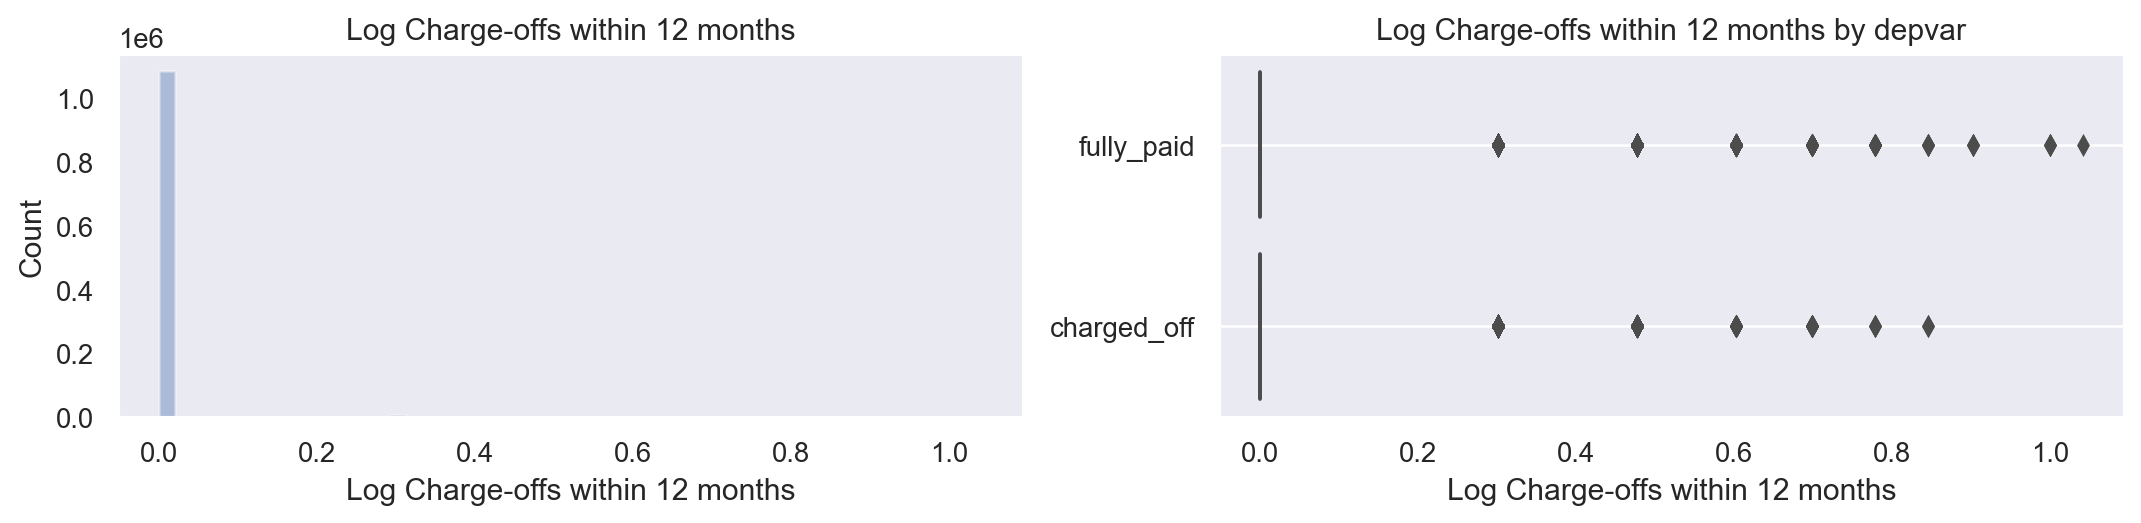

In [100]:
plot_var('log_chargeoff_within_12_mths', 'Log Charge-offs within 12 months', continuous=True)

In [101]:
loan.groupby('depvar')['log_chargeoff_within_12_mths'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,0.002852,0.030646,0.0,0.0,0.0,0.0,0.845098
fully_paid,916095.0,0.002680,0.029797,0.0,0.0,0.0,0.0,1.041393


### 2.3.15 delinq_amnt

의미: (The past-due amount owed for the accounts on which the borrower is now delinquent.)

In [102]:
loan.delinq_amnt.describe()

count    1.092919e+06
mean     1.640168e+01
std      8.274548e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.854080e+05
Name: delinq_amnt, dtype: float64

왜도가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [103]:
loan['log_delinq_amnt'] = loan['delinq_amnt'].apply(lambda x: np.log10(x+1))
loan.drop('delinq_amnt',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


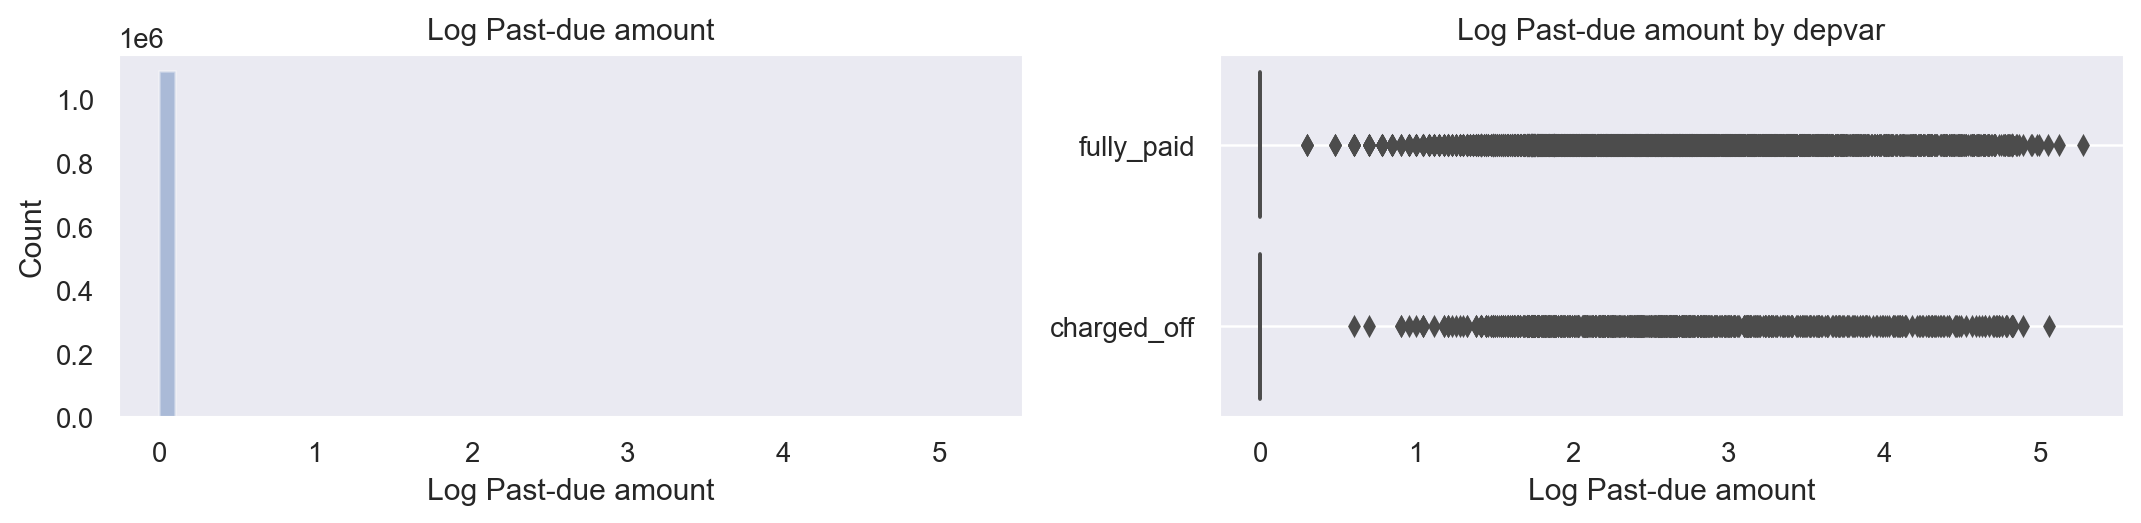

In [104]:
plot_var('log_delinq_amnt', 'Log Past-due amount', continuous=True)

In [105]:
loan.groupby('depvar')['log_delinq_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,0.012243,0.188972,0.0,0.0,0.0,0.0,5.051249
fully_paid,916095.0,0.010565,0.173254,0.0,0.0,0.0,0.0,5.268131


### 2.3.16 pub_rec_bankruptcies

의미: (Number of public record bankruptcies.)

In [106]:
loan.pub_rec_bankruptcies.describe()

count    1.092919e+06
mean     1.329669e-01
std      3.811488e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.200000e+01
Name: pub_rec_bankruptcies, dtype: float64

왜도가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [107]:
loan['log_pub_rec_bankruptcies'] = loan['pub_rec_bankruptcies'].apply(lambda x: np.log10(x+1))
loan.drop('pub_rec_bankruptcies',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


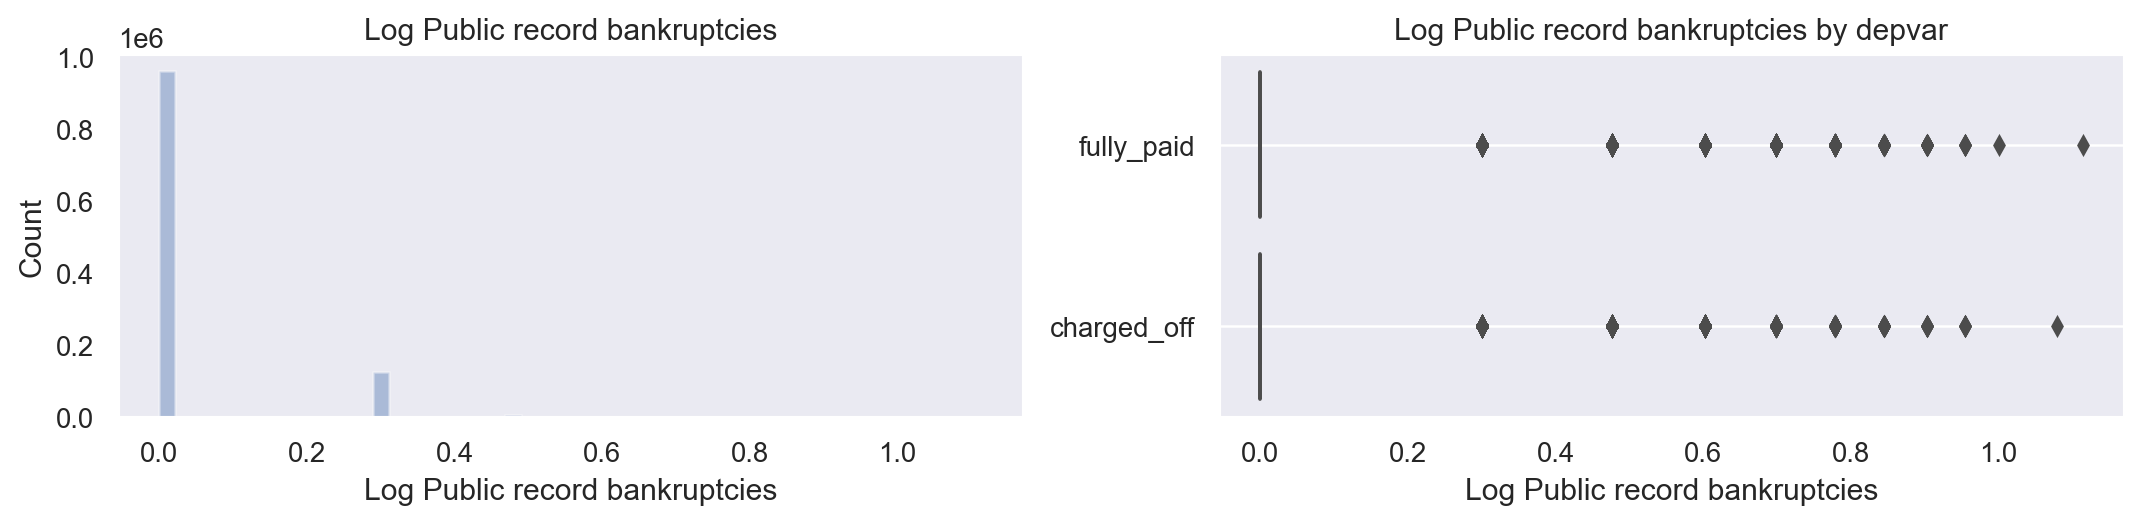

In [108]:
plot_var('log_pub_rec_bankruptcies', 'Log Public record bankruptcies', continuous=True)

In [109]:
loan.groupby('depvar')['log_pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,0.044817,0.112684,0.0,0.0,0.0,0.0,1.079181
fully_paid,916095.0,0.037268,0.103599,0.0,0.0,0.0,0.0,1.113943


### 2.3.17 tax_liens

의미: (Number of tax liens.)

In [110]:
loan.tax_liens.describe()

count    1.092919e+06
mean     6.108504e-02
std      4.397524e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.500000e+01
Name: tax_liens, dtype: float64

왜도가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [111]:
loan['log_tax_liens'] = loan['tax_liens'].apply(lambda x: np.log10(x+1))
loan.drop('tax_liens',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


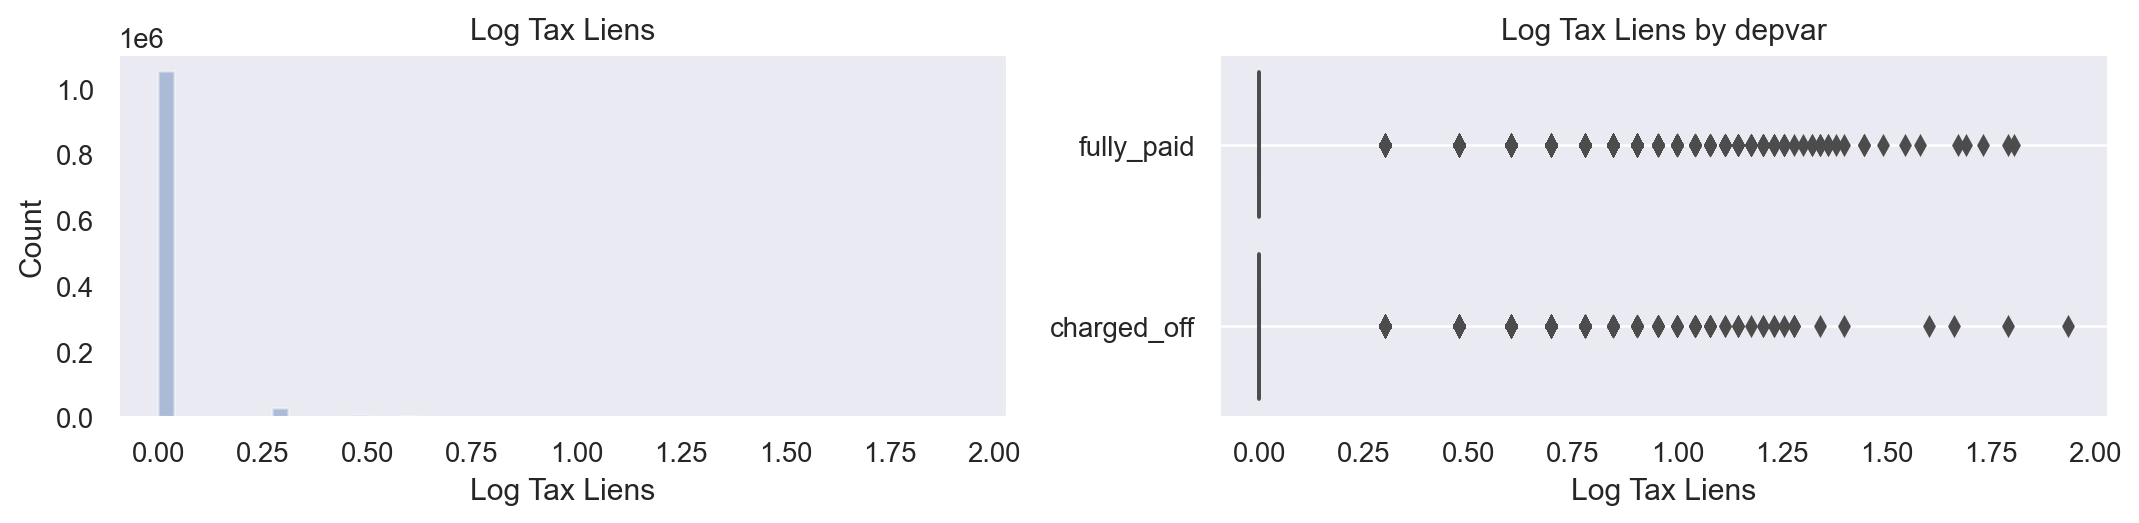

In [112]:
plot_var('log_tax_liens', 'Log Tax Liens', continuous=True)

In [113]:
loan.groupby('depvar')['log_tax_liens'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,0.015771,0.082281,0.0,0.0,0.0,0.0,1.934498
fully_paid,916095.0,0.014156,0.078293,0.0,0.0,0.0,0.0,1.806180


### 2.3.18 emp_length

의미: (Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.)

In [114]:
loan.emp_length.describe()

count     1092919
unique         12
top          10+ 
freq       360905
Name: emp_length, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


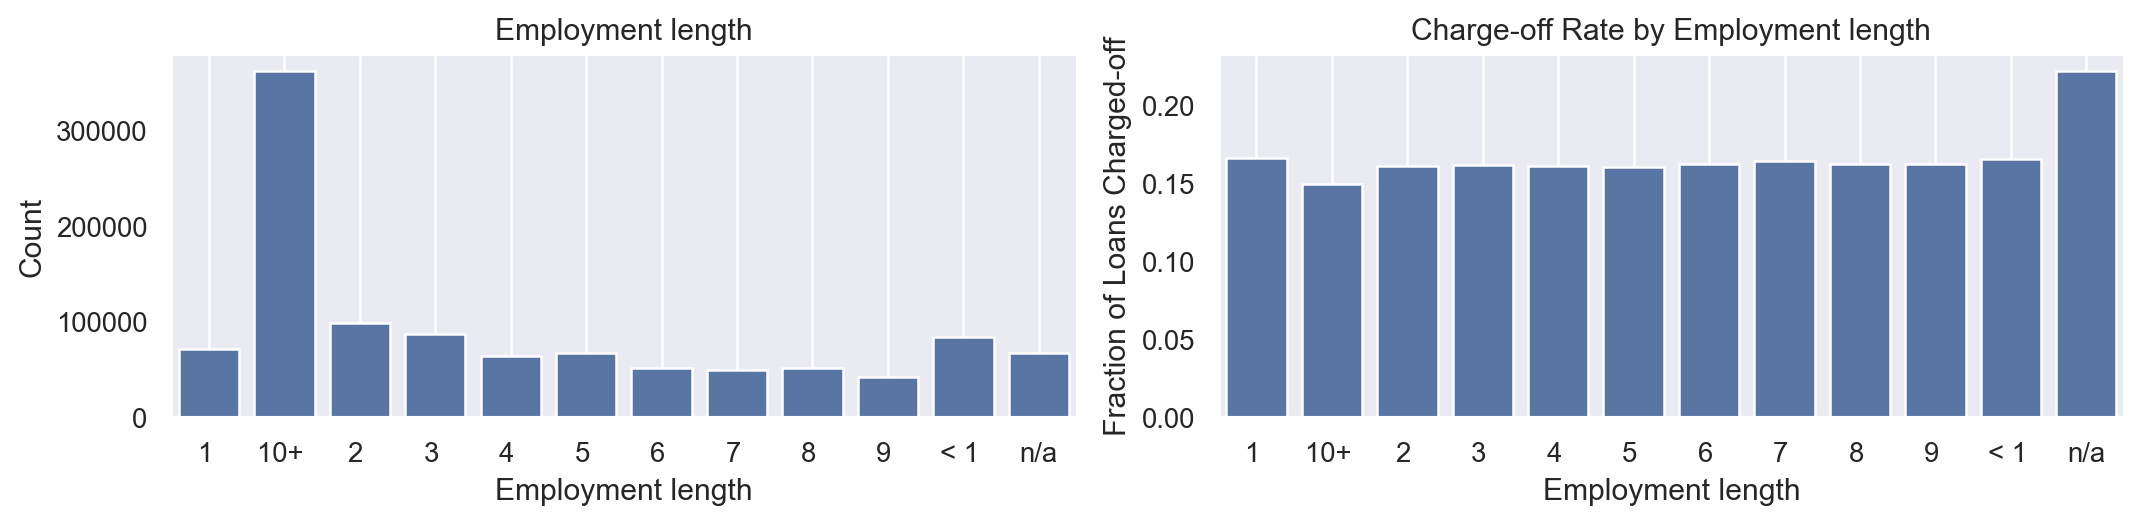

In [115]:
plot_var('emp_length', 'Employment length', continuous=False)

### 2.3.19 home_ownership

의미: (The home ownership status provided by the borrower during registration or obtained from the credit report.)

In [116]:
loan.home_ownership.describe()

count      1092919
unique           6
top       MORTGAGE
freq        525834
Name: home_ownership, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


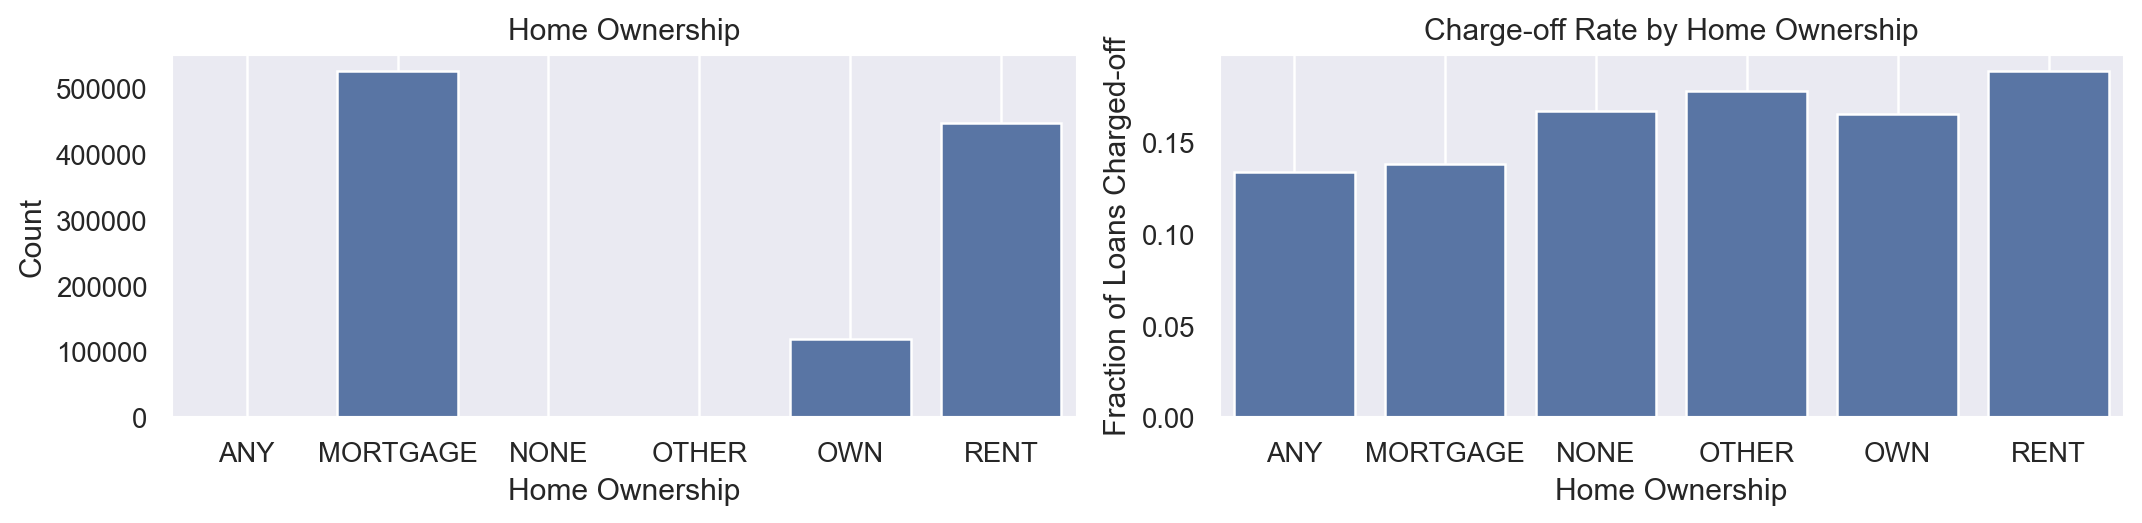

In [117]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

In [118]:
loan.groupby('depvar')['log_pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,0.044817,0.112684,0.0,0.0,0.0,0.0,1.079181
fully_paid,916095.0,0.037268,0.103599,0.0,0.0,0.0,0.0,1.113943


### 2.3.20 verification_status

의미: (Indicates if income was verified by LC, not verified, or if the income source was verified.)

In [119]:
loan.verification_status.describe()

count             1092919
unique                  3
top       Source Verified
freq               422358
Name: verification_status, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


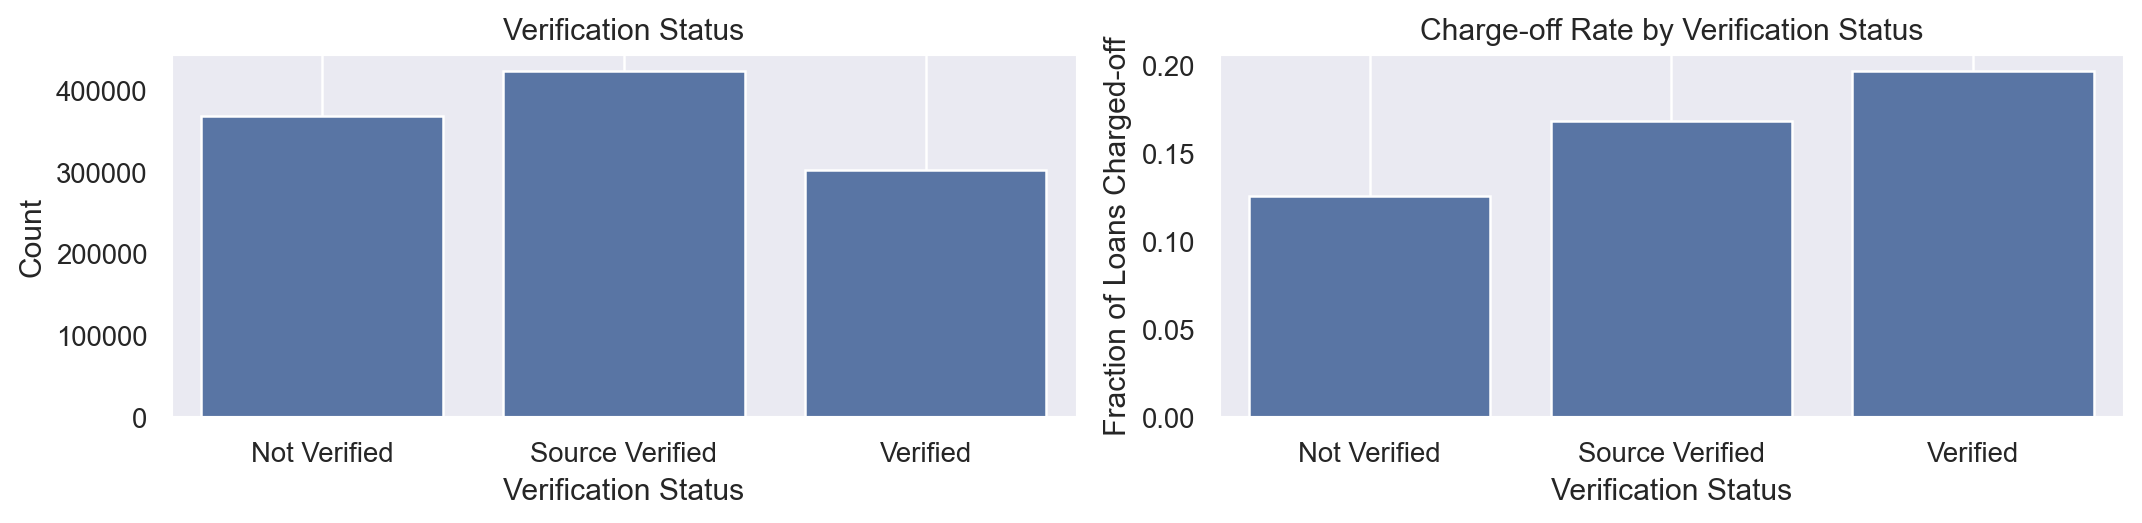

In [120]:
plot_var('verification_status', 'Verification Status', continuous=False)

### 2.3.21 purpose

의미: (A category provided by the borrower for the loan request.)

In [121]:
loan.purpose.describe()

count                1092919
unique                    14
top       debt_consolidation
freq                  629913
Name: purpose, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


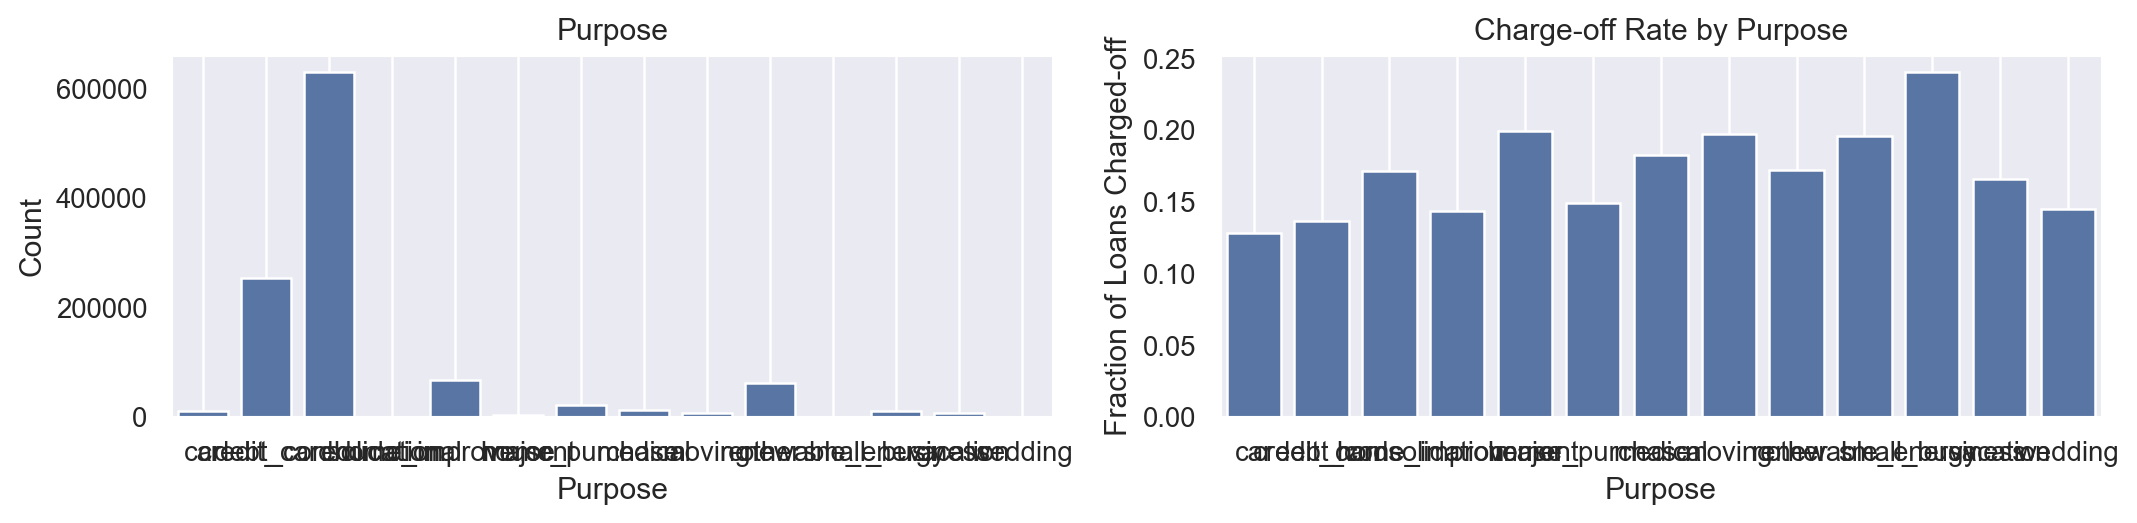

In [122]:
plot_var('purpose', 'Purpose', continuous=False)

### 2.3.22 addr_state

의미: (The state provided by the borrower in the loan application.)

In [123]:
loan.addr_state.describe()

count     1092919
unique         51
top            CA
freq       157394
Name: addr_state, dtype: object

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


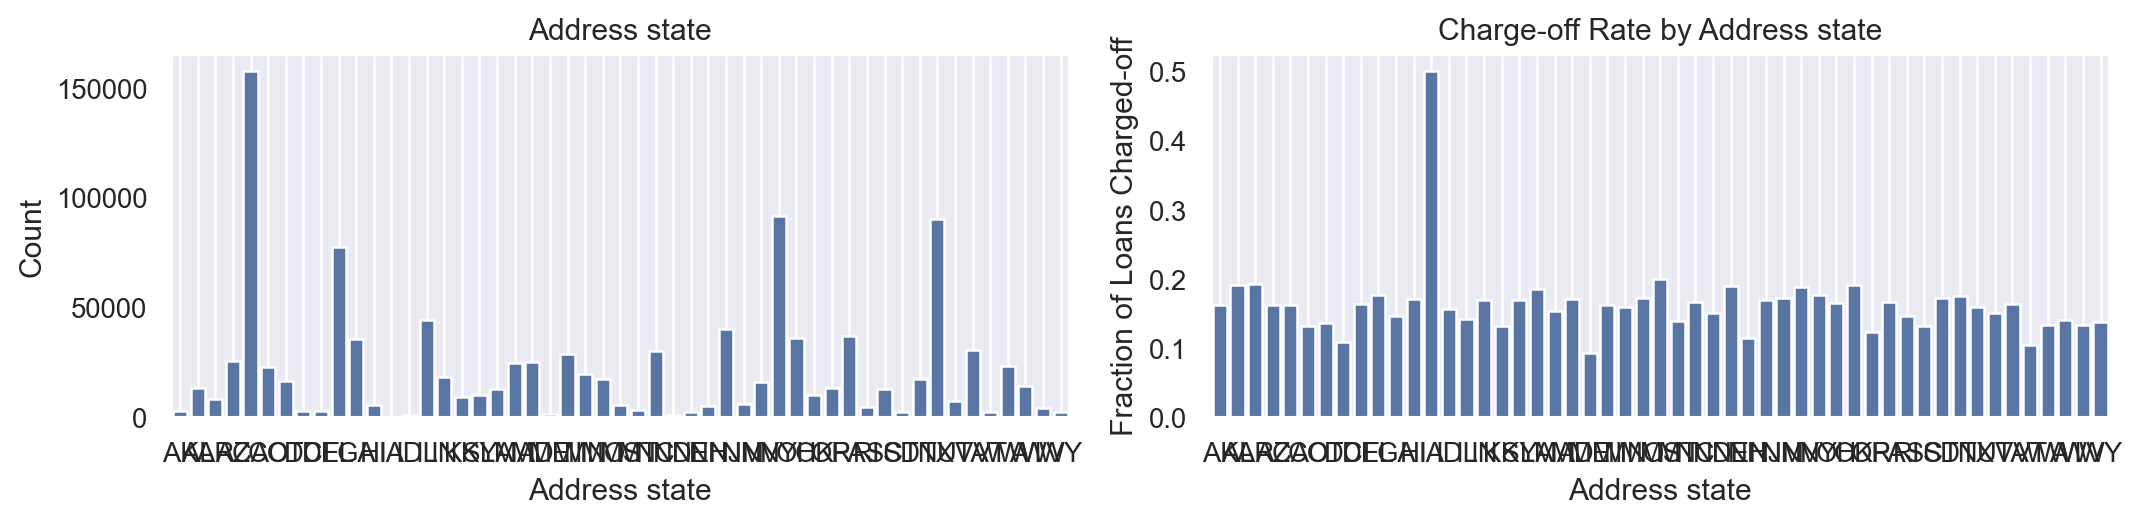

In [124]:
plot_var('addr_state', 'Address state', continuous=False)

### 2.3.23 mths_since_last_delinq

의미: (The number of months since the borrower's last delinquency.)

In [125]:
loan.mths_since_last_delinq.describe()

count    1.092919e+06
mean     2.771869e+00
std      3.414270e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      6.000000e+00
max      1.000000e+01
Name: mths_since_last_delinq, dtype: float64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


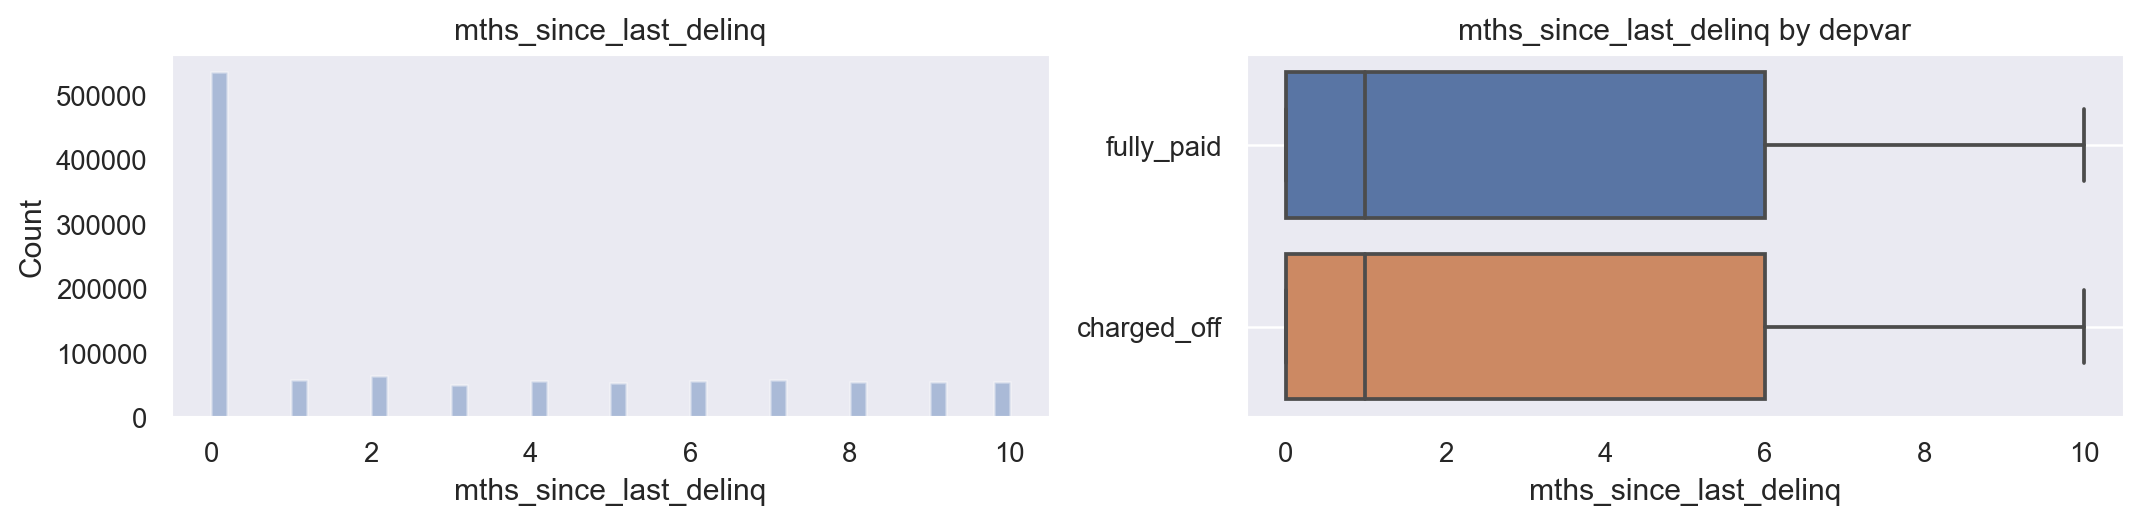

In [126]:
plot_var('mths_since_last_delinq', 'mths_since_last_delinq', continuous=True)

In [127]:
loan.groupby('depvar')['mths_since_last_delinq'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,2.824215,3.421004,0.0,0.0,1.0,6.0,10.0
fully_paid,916095.0,2.761765,3.412878,0.0,0.0,1.0,6.0,10.0


### 2.3.24 mths_since_last_major_derog

의미: (Months since most recent 90-day or worse rating.)

In [128]:
loan.mths_since_last_major_derog.describe()

count    1.092919e+06
mean     1.512169e+00
std      2.870919e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+01
Name: mths_since_last_major_derog, dtype: float64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


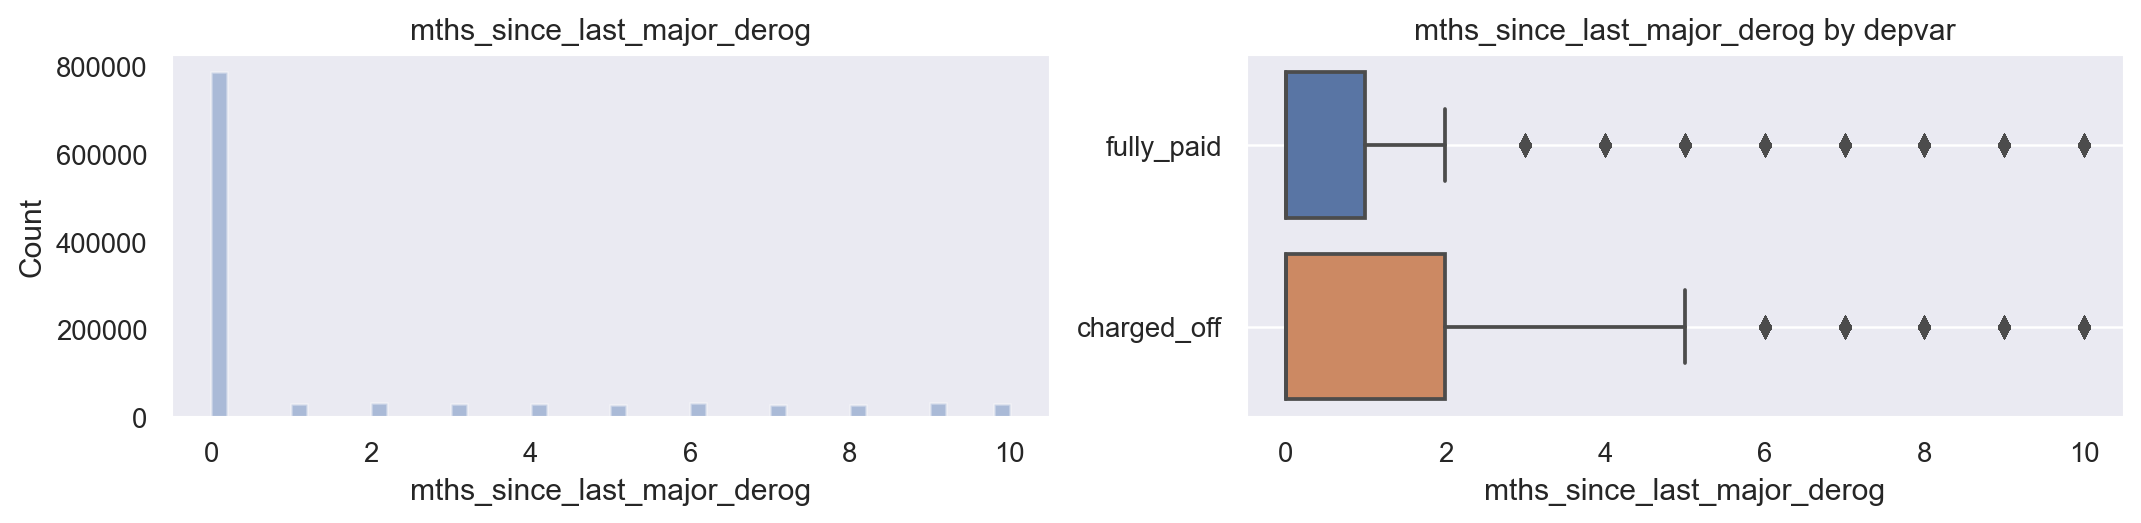

In [129]:
plot_var('mths_since_last_major_derog', 'mths_since_last_major_derog', continuous=True)

In [130]:
loan.groupby('depvar')['mths_since_last_major_derog'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,1.644420,2.963133,0.0,0.0,0.0,2.0,10.0
fully_paid,916095.0,1.486642,2.852073,0.0,0.0,0.0,1.0,10.0


### 2.3.25 mths_since_last_record

의미: (The number of months since the last public record.)

In [131]:
loan.mths_since_last_record.describe()

count    1.092919e+06
mean     9.439364e-01
std      2.375074e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+01
Name: mths_since_last_record, dtype: float64

왜도가 크므로 로그값으로 변환
 (모든 관측치는 0이상의 값)

In [132]:
loan['log_mths_since_last_record'] = loan['mths_since_last_record'].apply(lambda x: np.log10(x+1))
loan.drop('mths_since_last_record',axis=1,inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


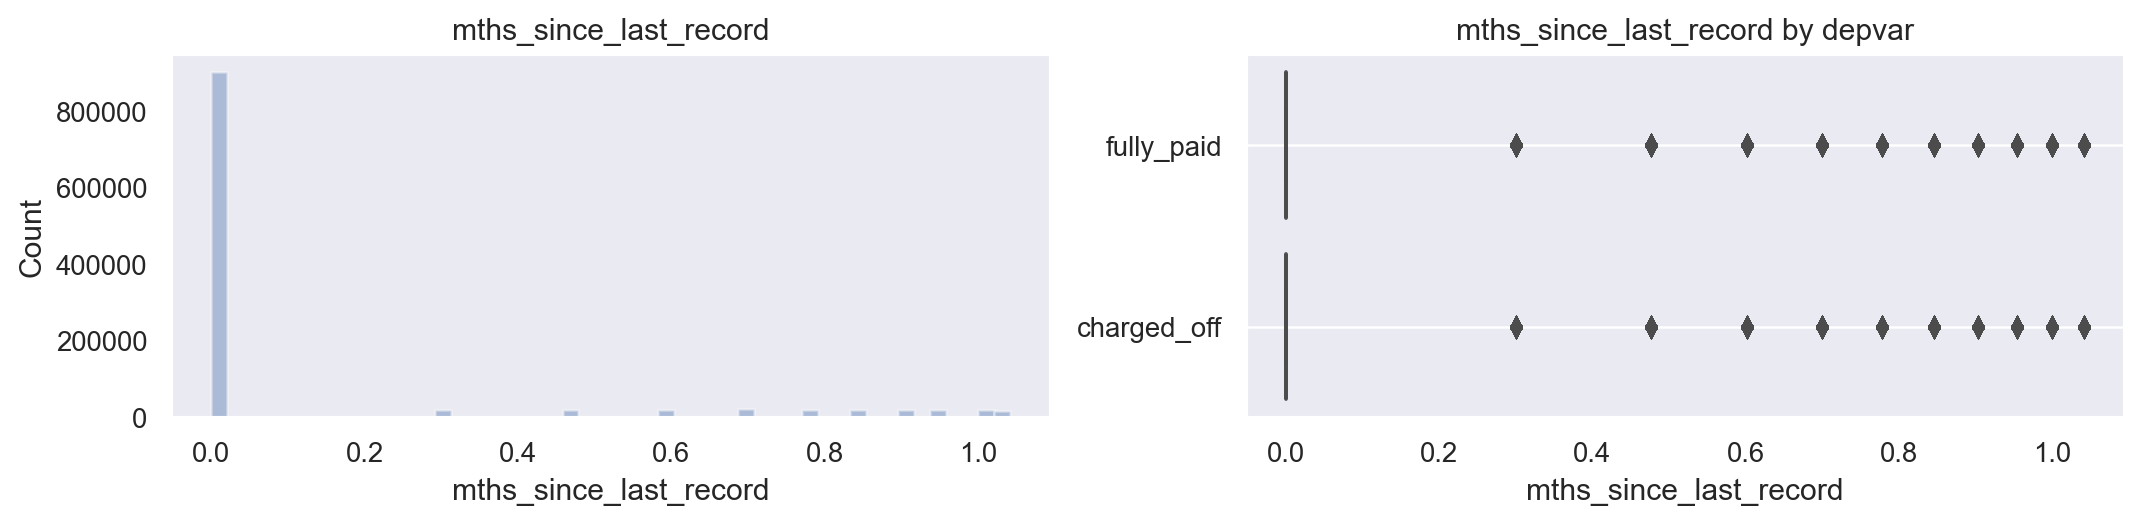

In [133]:
plot_var('log_mths_since_last_record', 'mths_since_last_record', continuous=True)

In [134]:
loan.groupby('depvar')['log_mths_since_last_record'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,0.152133,0.321535,0.0,0.0,0.0,0.0,1.041393
fully_paid,916095.0,0.127437,0.297473,0.0,0.0,0.0,0.0,1.041393


### 2.3.26 mths_since_rcnt_il

의미: (Months since most recent installment accounts opened.)

In [135]:
loan.mths_since_rcnt_il.describe()

count    1.092919e+06
mean     1.910855e+00
std      3.122094e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e+00
max      1.000000e+01
Name: mths_since_rcnt_il, dtype: float64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


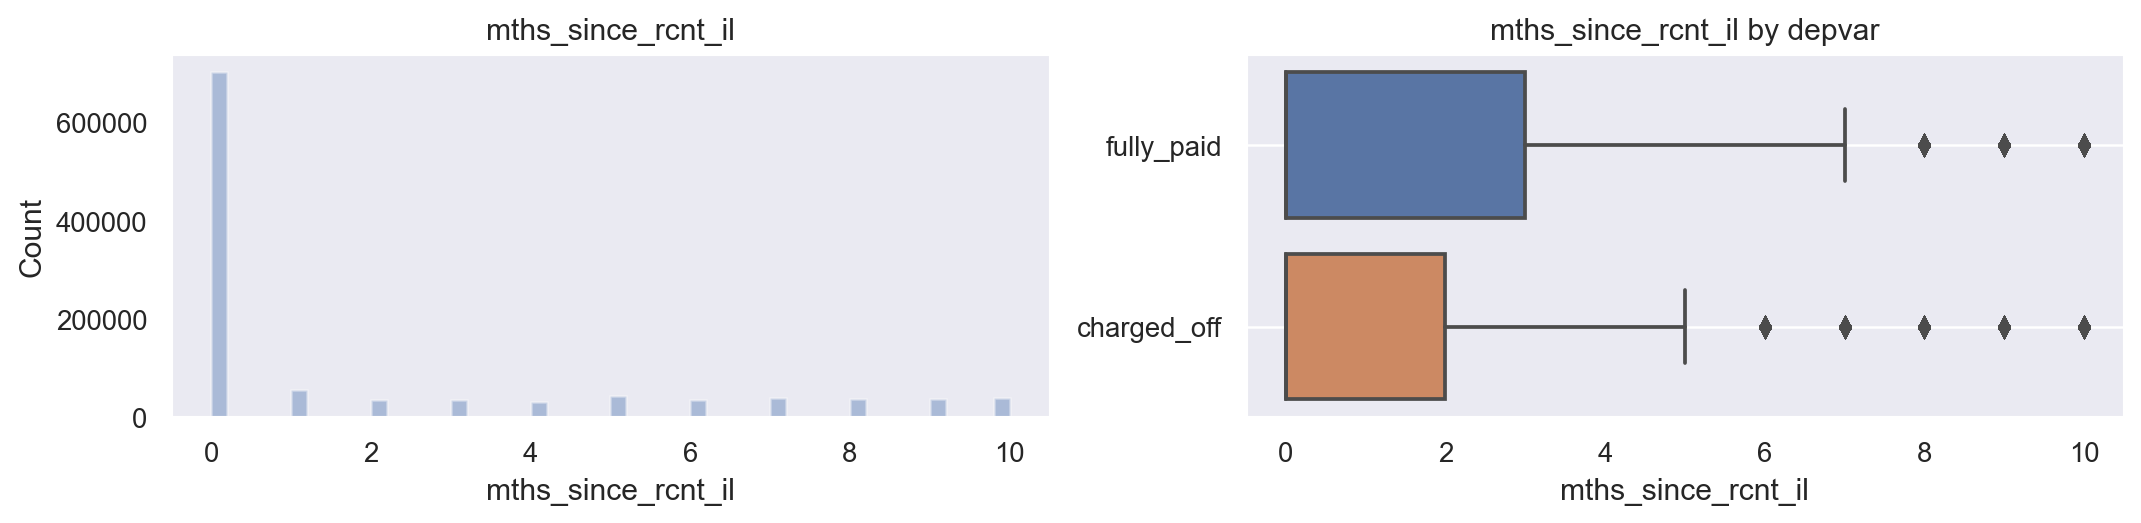

In [136]:
plot_var('mths_since_rcnt_il', 'mths_since_rcnt_il', continuous=True)

In [137]:
loan.groupby('depvar')['mths_since_rcnt_il'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,1.681768,2.907510,0.0,0.0,0.0,2.0,10.0
fully_paid,916095.0,1.955073,3.159927,0.0,0.0,0.0,3.0,10.0


### 2.3.27 mths_since_recent_bc

의미: (Months since most recent bankcard account opened.)

In [138]:
loan.mths_since_recent_bc.describe()

count    1.092919e+06
mean     5.312514e+00
std      2.971048e+00
min      0.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: mths_since_recent_bc, dtype: float64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


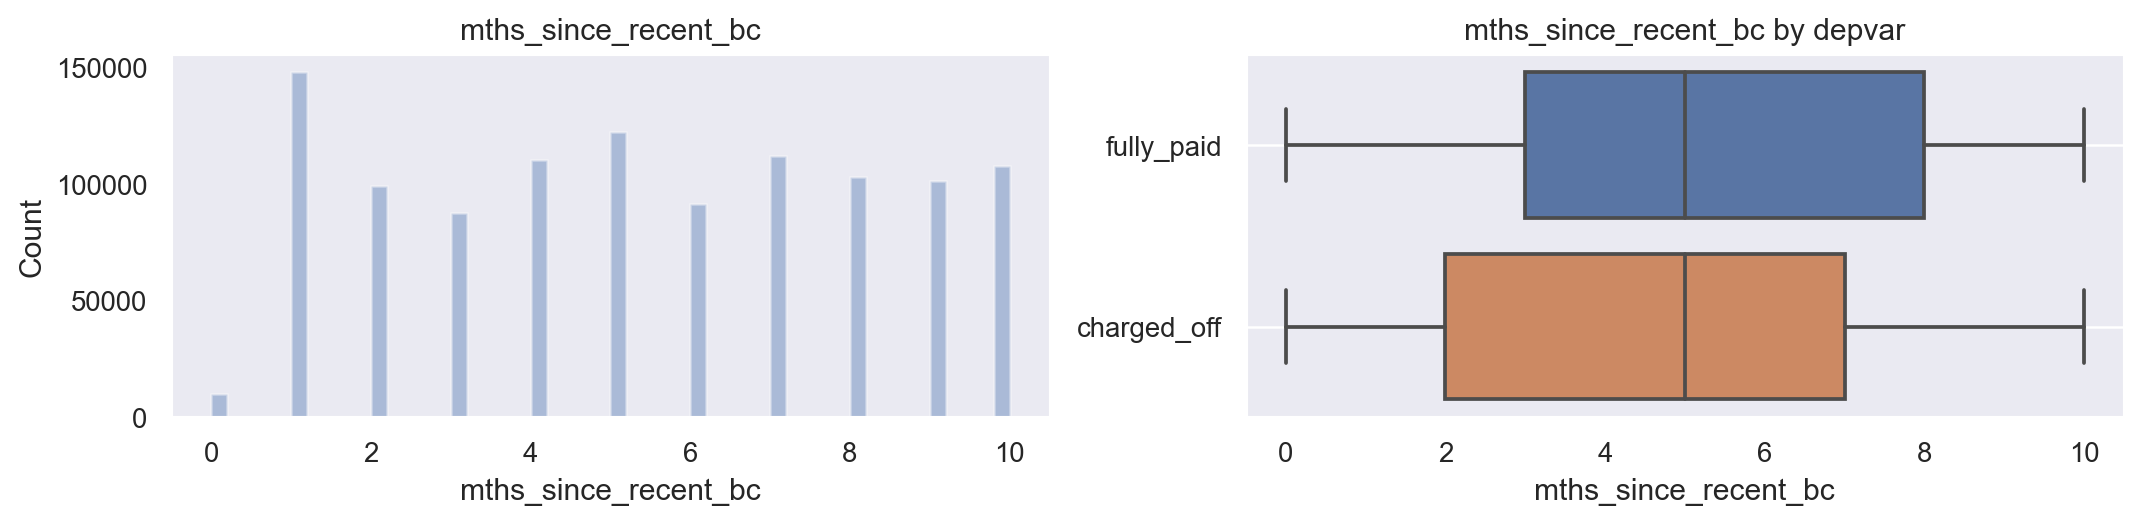

In [139]:
plot_var('mths_since_recent_bc', 'mths_since_recent_bc', continuous=True)

In [140]:
loan.groupby('depvar')['mths_since_recent_bc'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,4.895461,2.903778,0.0,2.0,5.0,7.0,10.0
fully_paid,916095.0,5.393014,2.977140,0.0,3.0,5.0,8.0,10.0


### 2.3.28 mths_since_recent_bc_dlq

의미: (Months since most recent bankcard delinquency.)

In [141]:
loan.mths_since_recent_bc_dlq.describe()

count    1.092919e+06
mean     1.382854e+00
std      2.774693e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+01
Name: mths_since_recent_bc_dlq, dtype: float64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


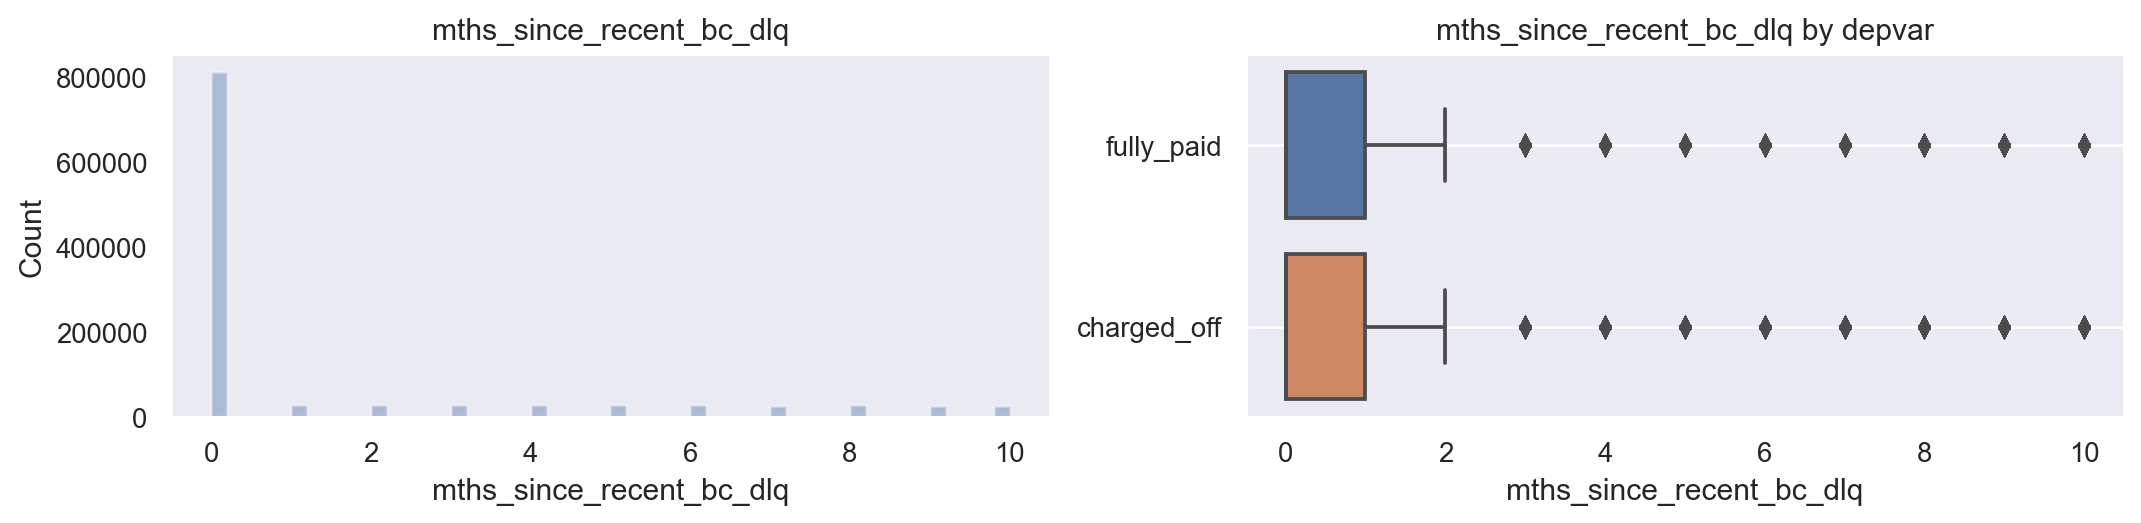

In [142]:
plot_var('mths_since_recent_bc_dlq', 'mths_since_recent_bc_dlq', continuous=True)

In [143]:
loan.groupby('depvar')['mths_since_recent_bc_dlq'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,1.436638,2.820835,0.0,0.0,0.0,1.0,10.0
fully_paid,916095.0,1.372472,2.765579,0.0,0.0,0.0,1.0,10.0


### 2.3.29 mths_since_recent_inq

의미: (Months since most recent inquiry.)

In [144]:
loan.mths_since_recent_inq.describe()

count    1.092919e+06
mean     4.651597e+00
std      3.265504e+00
min      0.000000e+00
25%      1.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.000000e+01
Name: mths_since_recent_inq, dtype: float64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


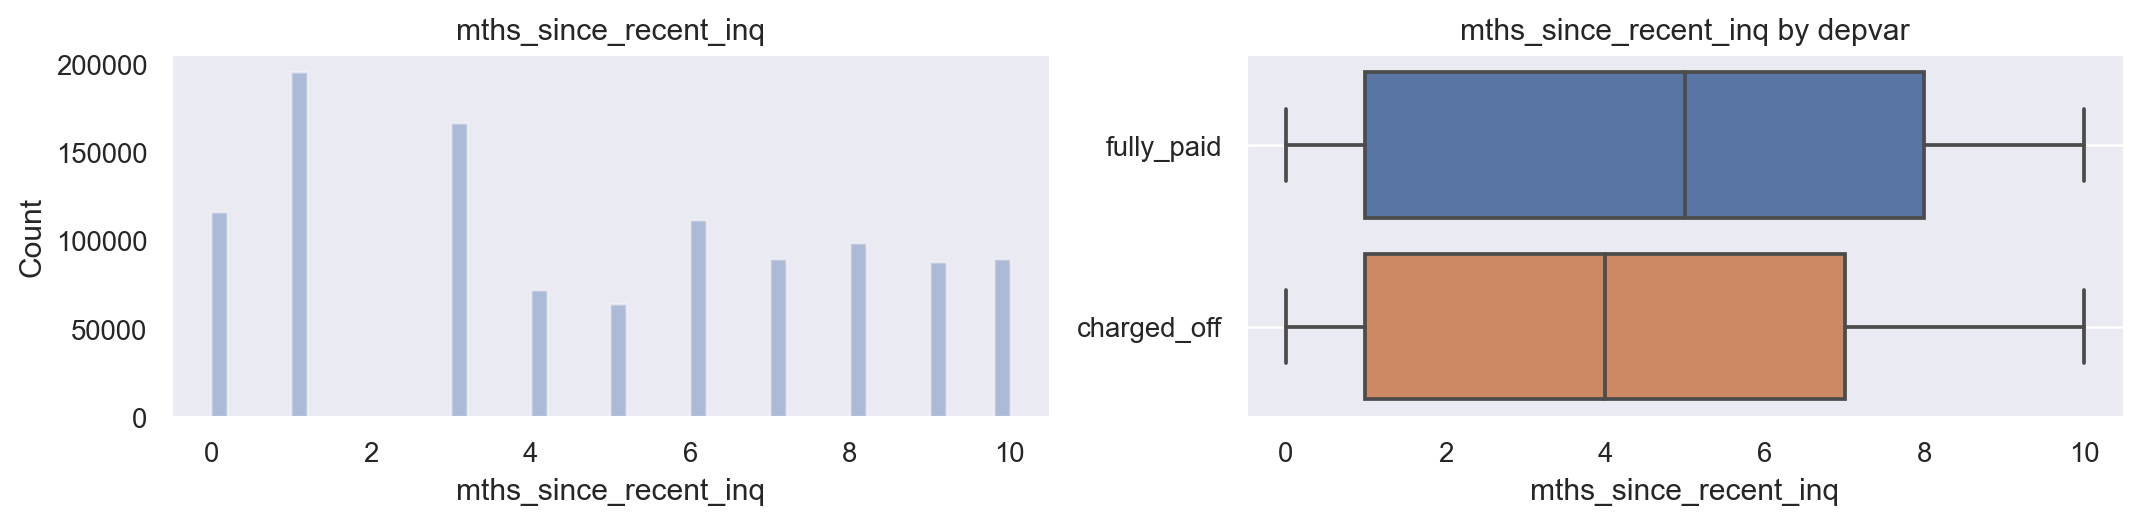

In [145]:
plot_var('mths_since_recent_inq', 'mths_since_recent_inq', continuous=True)

In [146]:
loan.groupby('depvar')['mths_since_recent_inq'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,4.456499,3.133724,0.0,1.0,4.0,7.0,10.0
fully_paid,916095.0,4.689255,3.289002,0.0,1.0,5.0,8.0,10.0


### 2.3.30 mths_since_recent_revol_delinq

의미: (Months since most recent revolving delinquency.)

In [147]:
loan.mths_since_recent_revol_delinq.describe()

count    1.092919e+06
mean     1.920091e+00
std      3.107172e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e+00
max      1.000000e+01
Name: mths_since_recent_revol_delinq, dtype: float64

/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


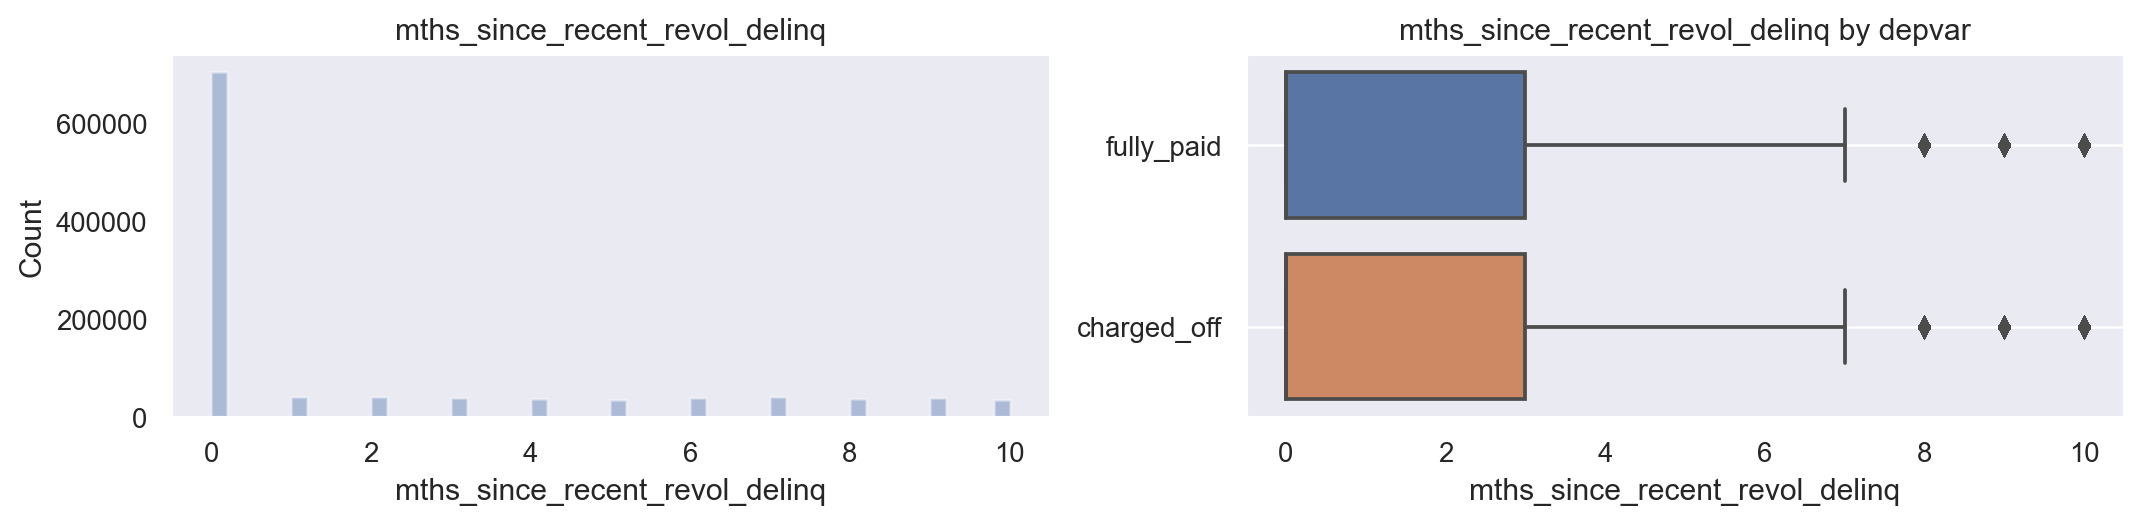

In [148]:
plot_var('mths_since_recent_revol_delinq', 'mths_since_recent_revol_delinq', continuous=True)

In [149]:
loan.groupby('depvar')['mths_since_recent_revol_delinq'].describe()

,count,mean,std,min,25%,50%,75%,max
depvar,,,,,,,,
charged_off,176824.0,1.948061,3.121402,0.0,0.0,0.0,3.0,10.0
fully_paid,916095.0,1.914692,3.104390,0.0,0.0,0.0,3.0,10.0


## 2.4. 전처리 필요사항

* 1. 변수 정리
    * 1-1. `fico_range_low`, `fico_range_high` 평균값을 `fico_score`에 저장하기
    * 1-2. `last_fico_range_low`, `last_fico_range_high` 평균값을 `last_fico_score`에 저장하기
    * 1-3. 수치형 데이터와 범주형 데이터 분리
* 2. 스케일링: 로그화, 정규화
* 3. 더미변수 만들기
    * 3-1. `emp_length` 그룹화 (5년 미만: 1 / 5년 이상 10년 미만: 2 / 10년 이상: 3)
    * 3-2. home_ownership 재그룹 (ANY, NONE을 OTHER에 통합
    * 3-3. 더미변수 만들기
    * 3-4. 결측치(emp_length의 NaN), 이상치(purpose의 educational, addr_state의 IA) 해당하는 더미 제거